In [1]:
import sys
import pandas as pd
import numpy as np

import os
import operator
import string
import re
import random
import warnings
warnings.filterwarnings('ignore')
import platform
import json, pickle
from collections import defaultdict

import scipy.stats as stats
from scipy.optimize import minimize
from scipy.stats import shapiro, probplot, beta, gaussian_kde

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.othermod.betareg import BetaModel

import pymc as pm

import sklearn as sk
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC, SVR

import deepchem as dc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mordred import Calculator, descriptors

from rdkit import Chem

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Users/seunghoonchoi/miniforge3/envs/medicine/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
# What version of Python do you have?
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Running on PyMC v{pm.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.5.2-arm64-arm-64bit
Tensor Flow Version: 2.13.0

Python 3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) 
[Clang 15.0.7 ]
Pandas 2.1.1
Scikit-Learn 1.3.1
Running on PyMC v5.8.2
GPU is NOT AVAILABLE


In [3]:
CFG = {
    'SEED':42,
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    check_random_state(seed)

seed_everything(CFG['SEED'])  # Seed 고정

In [5]:
train = pd.read_csv('/Users/seunghoonchoi/Downloads/SKKU KDT 2기/공모전/Dacon_making_new_medicine/Data/train.csv')
test = pd.read_csv('/Users/seunghoonchoi/Downloads/SKKU KDT 2기/공모전/Dacon_making_new_medicine/Data/test.csv')

In [6]:
train

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51


In [7]:
# AlogP 결측치 2개 있음.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3496 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


In [8]:
train.describe()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
count,3498.000000,3498.000000,3496.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000
mean,37.384742,53.090206,2.841399,363.881846,4.016581,1.098628,4.561178,2.682156,79.747278
std,35.695993,36.080081,1.608073,79.527022,1.511091,0.976266,2.357243,1.666996,28.849229
min,0.000000,0.000000,-4.137000,172.180000,0.000000,0.000000,0.000000,-4.920000,3.240000
25%,2.433000,15.905500,1.833000,304.389750,3.000000,0.000000,3.000000,1.620000,60.150000
50%,26.193000,58.023000,2.889000,350.255000,4.000000,1.000000,4.000000,2.709000,77.525000
75%,70.807250,87.753000,3.958250,409.744750,5.000000,2.000000,6.000000,3.860000,96.540000
max,131.720000,135.336000,9.190000,1360.467000,15.000000,10.000000,38.000000,9.190000,296.430000


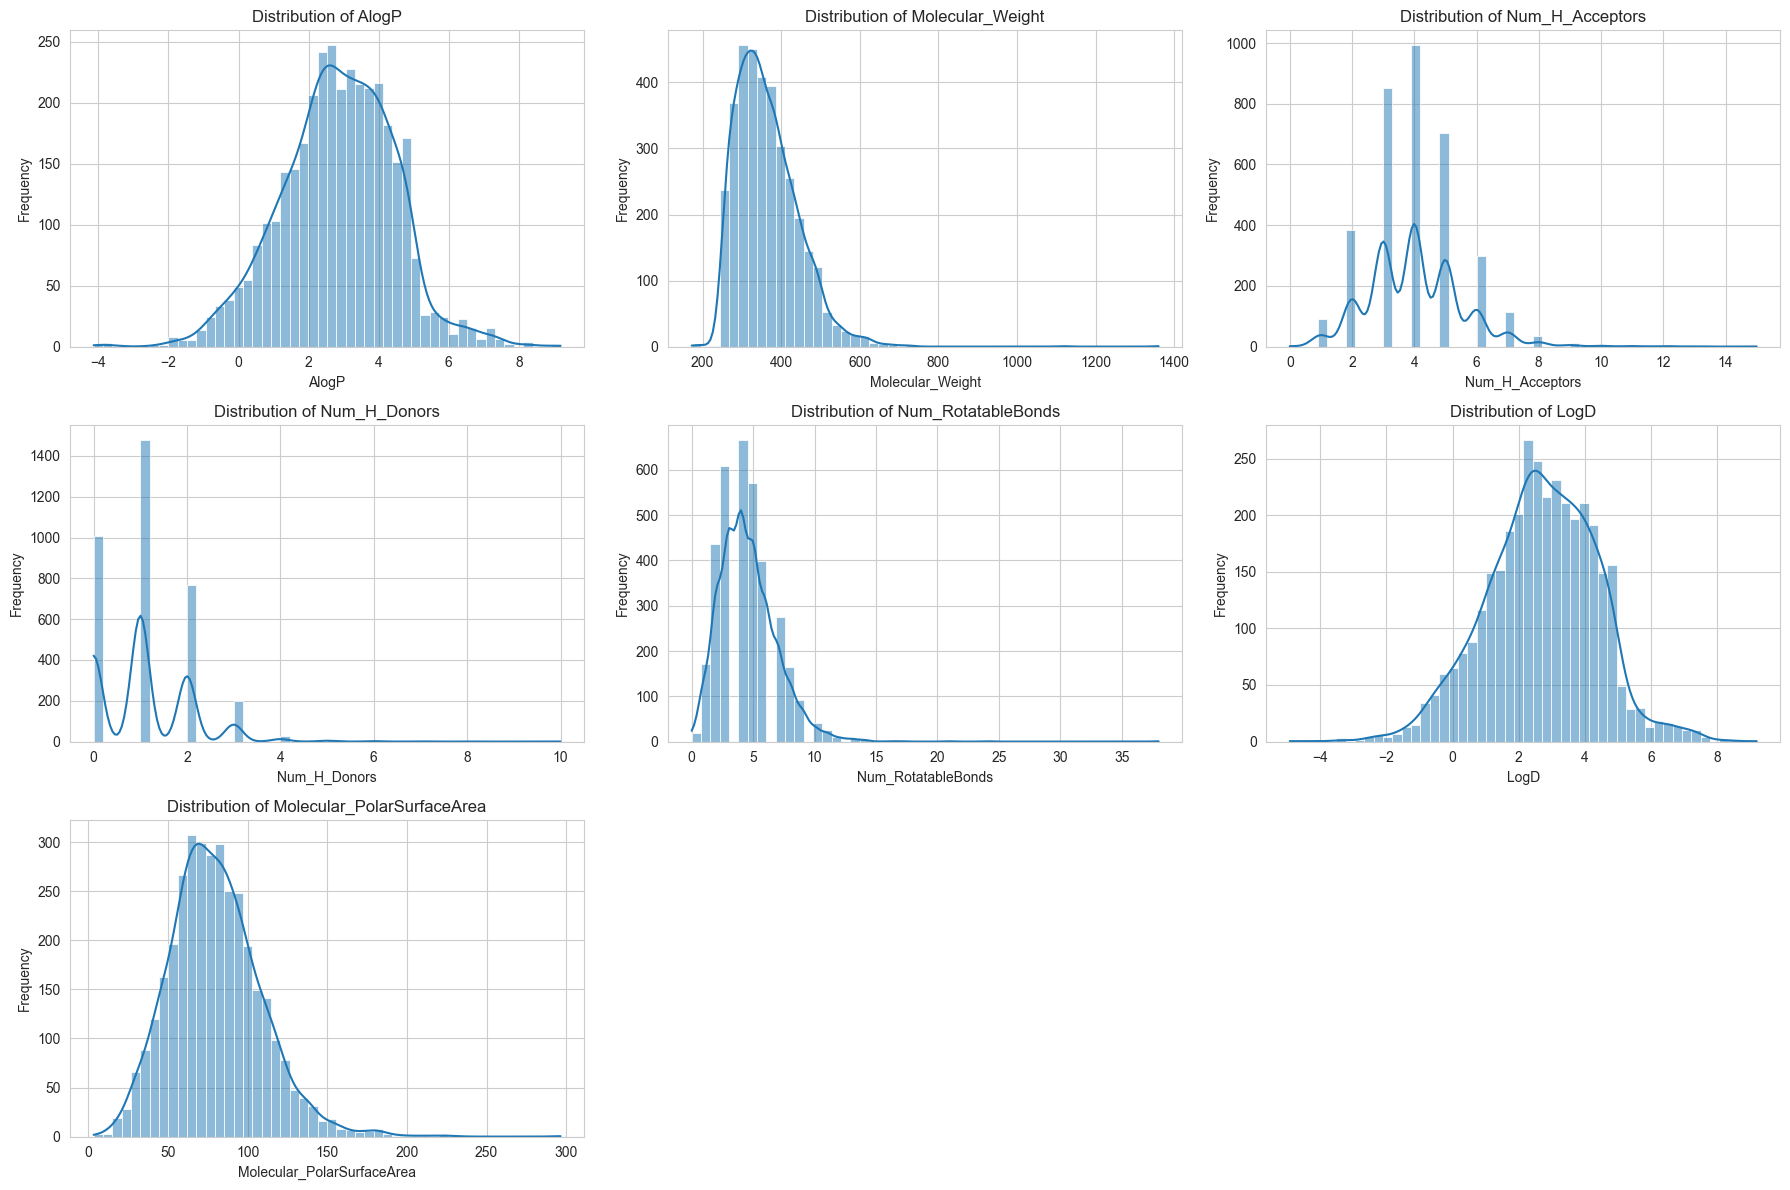

In [9]:
# 타겟, SMILES 제외한 변수들 분포 살펴보기
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# Subplots for each feature
features = ["AlogP", "Molecular_Weight", "Num_H_Acceptors", "Num_H_Donors", "Num_RotatableBonds", "LogD", "Molecular_PolarSurfaceArea"]
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

<Figure size 1200x900 with 0 Axes>

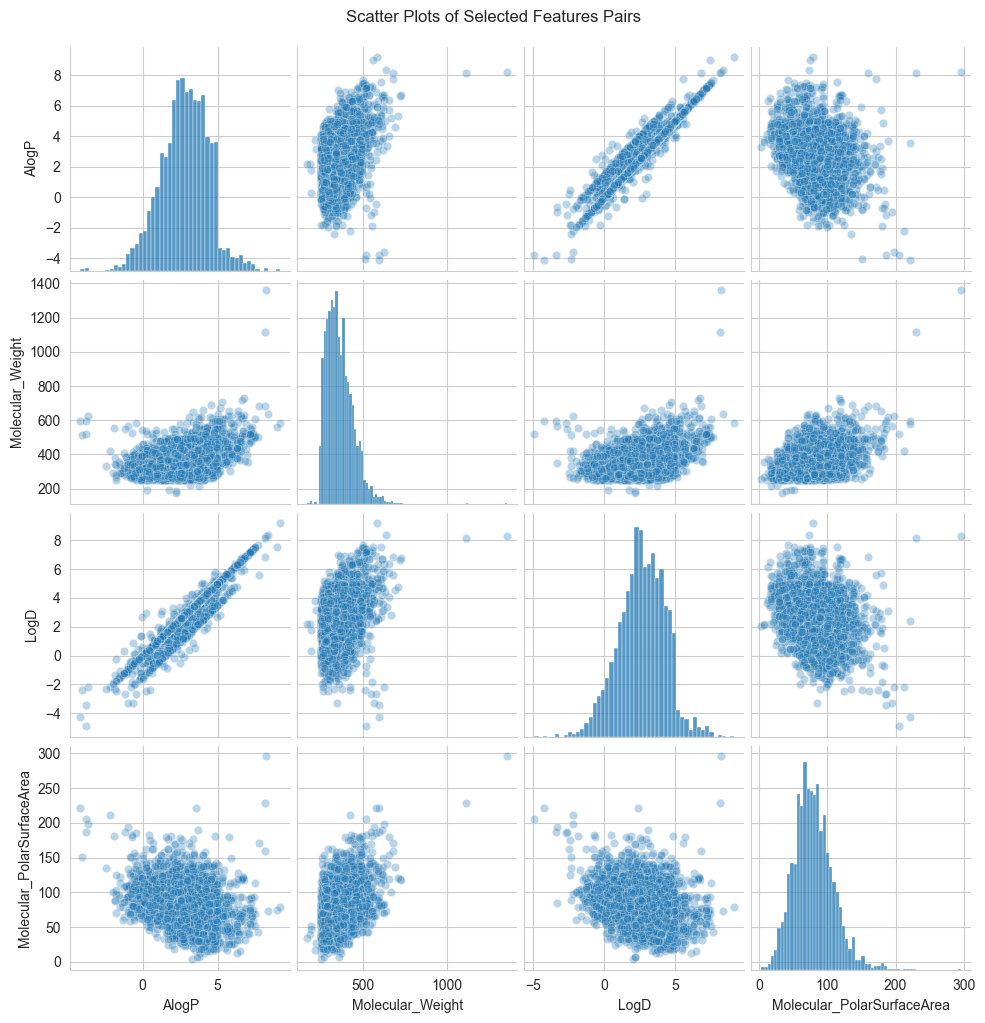

In [10]:
# AlogP와 LogD가 거의 1에 가까운 상관관계를 가짐
selected_features = ['AlogP', 'Molecular_Weight', 'Num_H_Acceptors', 
                    'Num_H_Donors', 'Num_RotatableBonds', 'LogD', 'Molecular_PolarSurfaceArea']

selected_features_with_targets = selected_features + ['MLM', 'HLM']

# Compute the correlation matrix including MLM and HLM
corr_with_targets = train[selected_features_with_targets].corr()

# Draw the correlation heatmap
plt.figure(figsize=(12, 9))
sns.pairplot(data=train, vars=["AlogP", "Molecular_Weight", "LogD", "Molecular_PolarSurfaceArea"], 
            plot_kws={'alpha':0.3})
plt.suptitle('Scatter Plots of Selected Features Pairs', y=1.02)
plt.show()

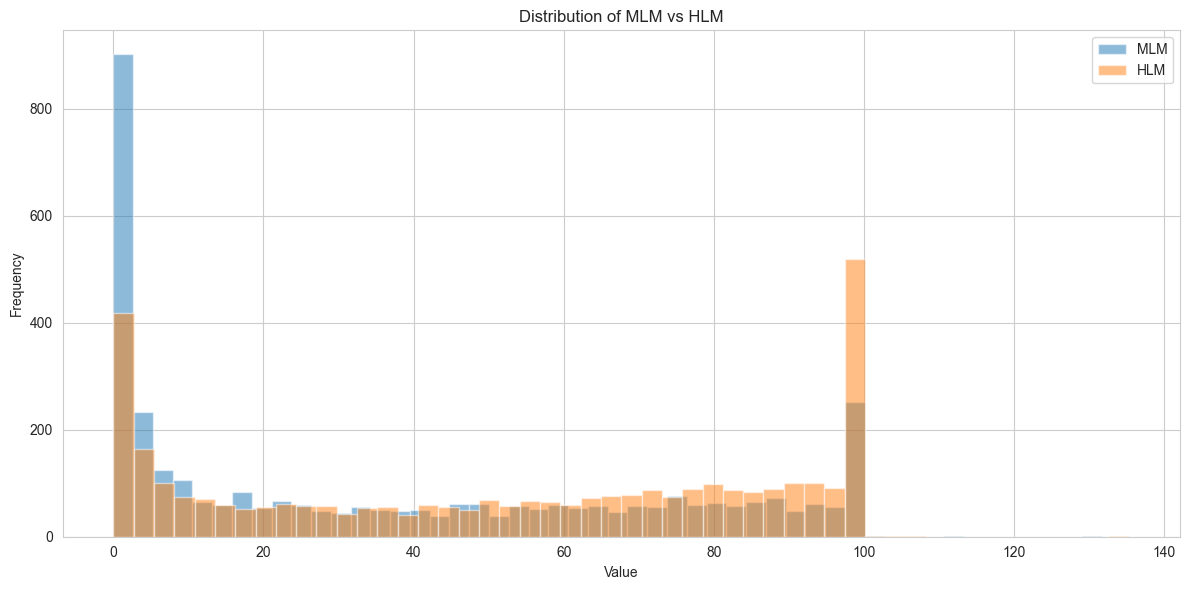

,MLM,HLM
count,3498.000000,3498.000000
mean,37.384742,53.090206
std,35.695993,36.080081
min,0.000000,0.000000
25%,2.433000,15.905500
50%,26.193000,58.023000
75%,70.807250,87.753000
max,131.720000,135.336000


In [11]:
# 겹쳐보기 + 기술통계 -> MLM 평균보다 HLM 평균이 더 크다
desc_stats = train[['MLM', 'HLM']].describe()

# Plot histograms for MLM and HLM
plt.figure(figsize=(12, 6))

plt.hist(train['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(train['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

desc_stats

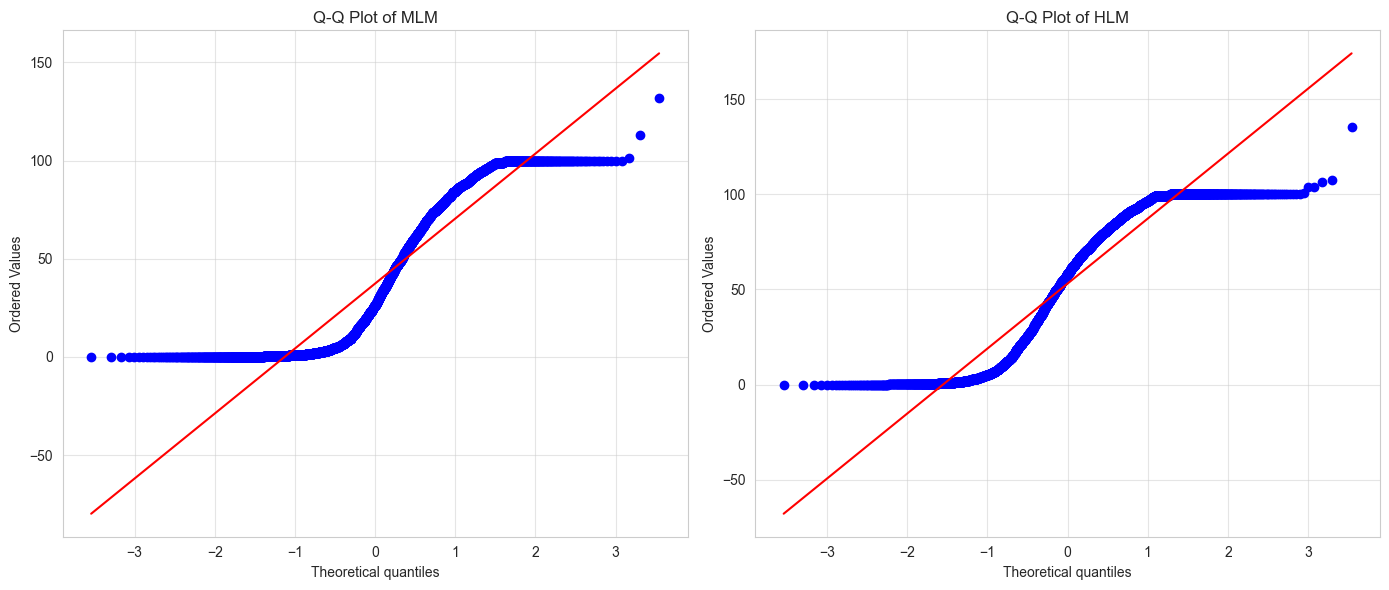

In [11]:
# 타겟 데이터의 분포 살펴보기 -> Gaussianity가 유지되는 구간과 깨지는 구간 살펴보기
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
stats.probplot(train['MLM'], dist="norm", plot=plt)
plt.title('Q-Q Plot of MLM')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.subplot(1, 2, 2)
stats.probplot(train['HLM'], dist="norm", plot=plt)
plt.title('Q-Q Plot of HLM')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [12]:
# Shapiro-Wilk test -> p-value가 0.05보다 작으므로, 정규분포를 따른다는 귀무가설을 기각, 정규분포를 따르지 않음
mlm_p_value = shapiro(train['MLM'])[1]
hlm_p_value = shapiro(train['HLM'])[1]
mlm_p_value, hlm_p_value

(0.0, 5.885453550164232e-44)

In [13]:
# id는 drop, AlogP 결측치는 LogD로 대체
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)
train['AlogP'].fillna(train['LogD'], inplace=True)
test['AlogP'].fillna(test['LogD'], inplace=True)

In [14]:
# MLM, HLM이 100이 넘는 값에 대한 주최측의 답변
'''
논리적으로는 아무리 안정한 물질이라도 100%를 넘는 값은 나올 수 없는 수치입니다.
그러나 간혹 용해도가 극히 좋지 않으면서 대사안정성이 높은 물질의 경우,
37도에서 30분간 반응하며 주어진 시간동안 실험 전보다 용해도가 더 증가하여 
반응 후 % remaining값이 반응 전 대비 더 큰 값으로 계산되는 경우도 발생될 수 있습니다.
모든 실험값들은 본 상황과 같은 문제를 포함하여 편차가 있을 수 있는 다양한 가능성이 있으므로 실측값들을 그대로 게시하였습니다.

-> 용해도가 안좋다 -> 약 흡수가 잘 안된다...
'''
train[(train['MLM'] >= 100) | (train['HLM'] >= 100)]

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
662,O=C(Nc1ccccc1)C1CCCN1C1=NS(=O)(=O)c2ccccc21,131.720,99.570,1.412,355.411,4,1,3,1.412,87.22
1092,COc1c(NC(=O)c2ccc[nH]2)cc(Cl)cc1C(=O)N(C)C,3.820,106.510,2.061,321.759,3,2,4,2.061,74.43
1584,CN(C)S(=O)(=O)CCNCc1ccc(-c2ccccc2)cc1,1.745,135.336,2.075,318.434,3,1,7,2.052,57.79
2159,N#Cc1nccnc1OC1CCN(C(=O)N2CCNC2=O)C1,113.210,99.000,-0.533,302.289,6,1,2,-0.533,111.44
2410,CC(C)CCC1CCN(C(=O)C2CC(O)CN2)CC1,86.878,107.323,1.345,268.395,3,2,4,0.139,52.57
2586,Cc1nc(-c2c[nH]c(C(=O)N3CCOc4cc(F)ccc43)c2)cs1,98.550,103.720,2.876,343.375,3,1,2,3.032,86.46
2948,CCCC(=O)Nc1cc(C(=O)NC2CCCCC2)ccc1S(=O)(=O)c1cc...,101.380,52.330,4.906,462.989,4,2,7,4.906,100.72
3157,CN1C(=O)c2cccc3c2C1=Cc1ccc2ccccc2c1O3,52.847,103.907,3.319,299.323,2,0,0,3.319,29.54
3403,c1cnc2c(C3NCCc4c3[nH]c3ccccc43)cccc2c1,8.890,100.830,3.719,299.369,2,2,1,3.719,40.71


In [15]:
# 100이 넘는 MLM과 HLM 값을 100으로 제한
train['MLM'] = train['MLM'].apply(lambda x: min(x, 100))
train['HLM'] = train['HLM'].apply(lambda x: min(x, 100))

In [16]:
# 중복값에 대한 주최측의 답변

'''
본 데이터는 생물학적 재료를 활용한 실험으로써,
동일 실험 조건이라도 실험 결과는 대사효소의 활성 정도나 반응 시간의 미세한 차이 등 여러가지 요인들에 편차가 발생합니다.
데이터의 신뢰성 확보를 위해, 제공된 대사안정성 데이터 값은 각각 n수를 3으로 하여 평균을 냈으며
MLM에서는 5% 이내, HLM에서는 10% 이내의 값이 나오는지 확인하였으므로, 편차는 제공하지 않습니다.
몇몇 데이터는 실험적 오차가 발생한 것으로 예측됩니다.
중복 값은 배치가 다른 실험에 대한 값입니다.
각 배치마다 reference 물질을 사용하여 확인하였으므로 실험계 전체의 오류는 없으나 batch 중 한 실험은 오류가 있는 것으로 예측되고, 
그와 같은 데이터가 포함될 가능성은 항상 있으므로 그러한 데이터의 처리가 중요하여 경진대회에 포함하였습니다.
'''

duplicate_smiles = train['SMILES'].duplicated(keep=False)
duplicates = train[duplicate_smiles].sort_values(by='SMILES')
duplicates

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [17]:
# 중복값의 각 편차가 30이 넘으면 둘 다 제거, 아니면 최대값으로(안정적인 값)
indices_to_keep = []
indices_to_drop = []

# Iterate over the 'duplicates' dataframe with a step of 2 (since they are pairs)
for i in range(0, len(duplicates), 2):
    row1 = duplicates.iloc[i]
    row2 = duplicates.iloc[i + 1]
    
    # Calculate the difference in the absolute differences for the pair
    diff_of_MLM = abs(row1['MLM'] - row2['MLM'])
    diff_of_HLM = abs(row1['HLM'] - row2['HLM'])
    
    # If the difference in the absolute differences is greater than 30, drop both rows
    if diff_of_MLM > 30 or diff_of_HLM > 30:
        indices_to_drop.extend([row1.name, row2.name])
    else:
        # Otherwise, keep one row with maximum MLM and HLM values
        max_MLM = max(row1['MLM'], row2['MLM'])
        max_HLM = max(row1['HLM'], row2['HLM'])
        
        # Update the MLM and HLM values of the first row of the pair with the maximum values
        duplicates.at[row1.name, 'MLM'] = max_MLM
        duplicates.at[row1.name, 'HLM'] = max_HLM
        
        # Keep the first row and drop the second row of the pair
        indices_to_keep.append(row1.name)
        indices_to_drop.append(row2.name)

# Filter out the rows from 'duplicates' dataframe
filtered_duplicates = duplicates.loc[indices_to_keep]

filtered_duplicates

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
859,CCCCC/N=c1\n(C)c(=O)nc2sccn12,2.860,37.769,2.484,252.336,4,0,4,2.474,73.56
2534,CCOC(=O)CC1(NC(=O)N2Cc3c(sc4c3CCCC4)-n3cccc3C2...,5.884,5.540,6.727,537.736,3,1,6,6.727,120.05
1914,COC(=O)C1(CCCN(C)CCc2ccc(OC)c(OC)c2)CCCc2c1ccc...,12.690,17.971,5.374,485.612,7,0,13,3.870,66.46
2256,COc1ccc(C2=NOC(c3ccc(-c4nnn[nH]4)cc3)C2)cc1,72.473,21.930,2.235,321.333,6,1,4,1.806,85.28
1968,COc1ccc(C2=NOC(c3ccsc3)C2)cc1,8.144,11.348,2.868,259.324,3,0,3,2.868,59.06
2081,COc1ccc([C@H]2Oc3cc(OC)cc(OC)c3C[C@H]2O)cc1,0.829,7.530,2.940,316.348,5,1,4,2.940,57.15


In [18]:
# Remove the original duplicates from the train dataframe
train = train.drop(indices_to_drop)

# Append the processed duplicates to the train dataframe
train = pd.concat([train, filtered_duplicates])

# Sort the dataframe by index for consistency
train.reset_index(inplace=True, drop=True)

train.head(10)

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
5,COc1c(F)c(F)cc2c(=O)c(C(=O)NCCCN3CCCC3=O)cn(C3...,27.640,66.630,1.335,419.422,4,1,7,1.335,78.95
6,CN(C)c1cccc2c(S(=O)(=O)NC(CC(=O)O)C(=O)O)cccc12,82.107,69.250,1.954,547.707,7,4,9,0.464,144.42
7,C1=Cn2nc(/C=C/c3cccs3)nc2-c2ccccc2O1,2.673,25.121,2.967,293.343,3,0,2,2.967,68.18
8,COc1ccc2nc(C3=CCCN(C)C3)n(C)c2c1,74.519,71.471,-0.946,347.366,7,2,3,-0.723,104.89
9,CCN1CCCC1CNC(=O)C1CCCN(c2ncnc3[nH]cnc23)C1,73.417,76.291,1.259,357.453,5,2,5,-0.373,90.04


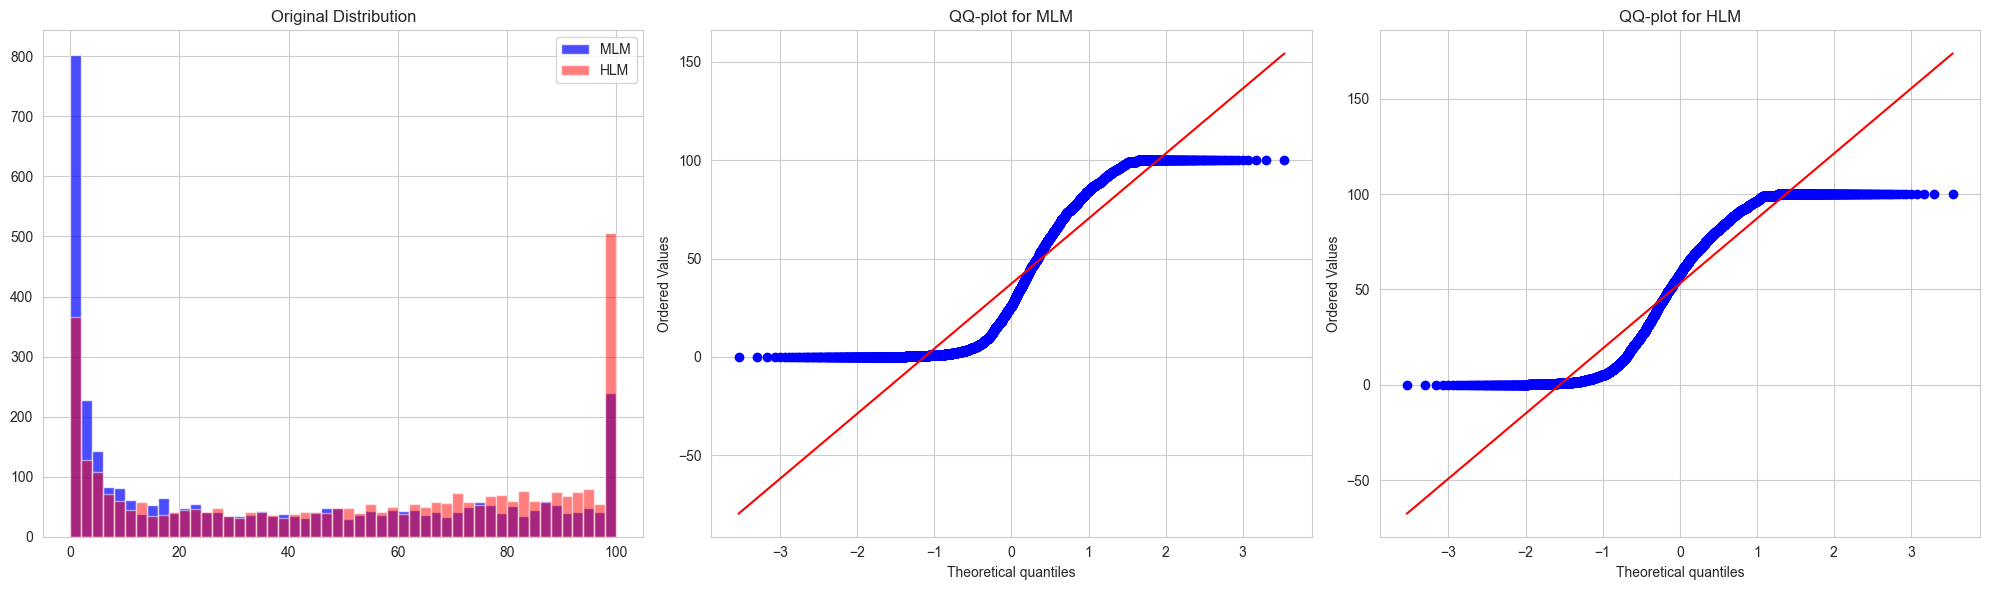

In [19]:
# 변환한 후, 타겟 데이터 분포 다시 살펴보기
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original Distribution
axes[0].hist(train['MLM'], bins=50, color='blue', alpha=0.7, label='MLM')
axes[0].hist(train['HLM'], bins=50, color='red', alpha=0.5, label='HLM')
axes[0].set_title('Original Distribution')
axes[0].legend()

# QQ-plot for MLM
probplot(train['MLM'], plot=axes[1])
axes[1].set_title('QQ-plot for MLM')

# QQ-plot for HLM
probplot(train['HLM'], plot=axes[2])
axes[2].set_title('QQ-plot for HLM')

plt.tight_layout()
plt.show()

In [20]:
def negative_log_likelihood(params, data):
    """Compute the negative log likelihood for the beta distribution."""
    a, b = params
    return -beta.logpdf(data, a, b).sum()

def initial_guess(data):
    """Compute initial guess for alpha and beta based on data's mean and variance."""
    mean = data.mean()
    var = data.var()
    
    alpha = mean * (mean * (1 - mean) / var - 1)
    beta = (1 - mean) * (mean * (1 - mean) / var - 1)
    
    return alpha, beta

# Normalize MLM and HLM data to be between 0 and 1
train['MLM_normalized'] = train['MLM'] / 100
train['HLM_normalized'] = train['HLM'] / 100

# Compute initial guesses for MLM and HLM
alpha0_mlm, beta0_mlm = initial_guess(train['MLM_normalized'])
alpha0_hlm, beta0_hlm = initial_guess(train['HLM_normalized'])

# Estimate parameters for MLM and HLM using the new initial guesses
result_mlm = minimize(negative_log_likelihood, [alpha0_mlm, beta0_mlm], args=(train['MLM_normalized'],), bounds=((0, None), (0, None)))
result_hlm = minimize(negative_log_likelihood, [alpha0_hlm, beta0_hlm], args=(train['HLM_normalized'],), bounds=((0, None), (0, None)))

result_mlm.x, result_hlm.x

(array([0.31395363, 0.52820375]), array([0.48698847, 0.43069286]))

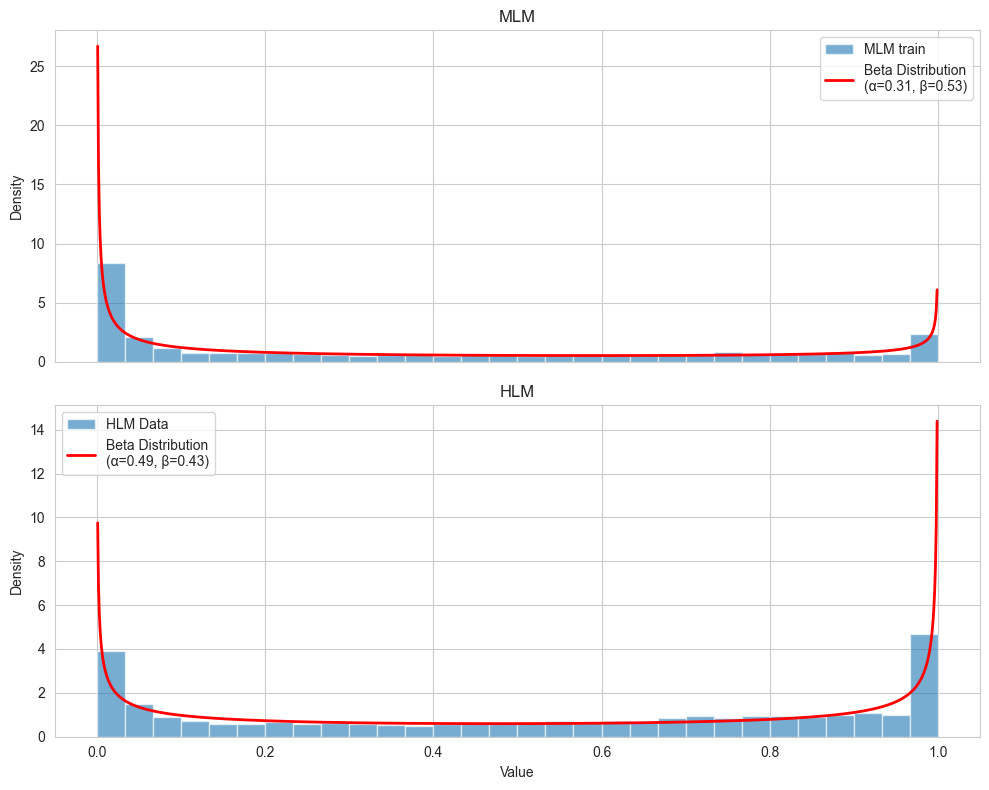

In [22]:
# Define a range of values for the x-axis
x = np.linspace(0, 1, 1000)

# Compute the PDF of the beta distribution for the estimated parameters
pdf_mlm = beta.pdf(x, result_mlm.x[0], result_mlm.x[1])
pdf_hlm = beta.pdf(x, result_hlm.x[0], result_hlm.x[1])

# Plot histograms and beta distribution curves
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# MLM plot
axes[0].hist(train['MLM_normalized'], bins=30, density=True, alpha=0.6, label='MLM train')
axes[0].plot(x, pdf_mlm, 'r-', lw=2, label=f'Beta Distribution\n(α={result_mlm.x[0]:.2f}, β={result_mlm.x[1]:.2f})')
axes[0].legend()
axes[0].set_title('MLM')
axes[0].set_ylabel('Density')

# HLM plot
axes[1].hist(train['HLM_normalized'], bins=30, density=True, alpha=0.6, label='HLM Data')
axes[1].plot(x, pdf_hlm, 'r-', lw=2, label=f'Beta Distribution\n(α={result_hlm.x[0]:.2f}, β={result_hlm.x[1]:.2f})')
axes[1].legend()
axes[1].set_title('HLM')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [21]:
calc = Calculator(descriptors, ignore_3D=True)
len(calc.descriptors)

1613

In [22]:
x_train = calc.pandas([Chem.MolFromSmiles(x) for x in train.SMILES])
x_train

100%|██████████| 3474/3474 [03:13<00:00, 17.98it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,21.379612,17.449011,0,0,35.689316,2.421199,4.745523,35.689316,1.274618,4.249154,...,10.081676,78.761075,400.156912,7.695325,2380,40,142.0,165.0,9.500000,6.361111
1,16.539255,14.049653,0,0,26.575899,2.426398,4.757199,26.575899,1.265519,3.984419,...,9.907828,69.149596,301.124883,7.528122,870,35,112.0,132.0,7.138889,4.527778
2,17.475469,13.660693,2,1,29.802128,2.510668,4.982923,29.802128,1.354642,4.049690,...,10.144510,70.158066,297.170194,7.248054,1028,36,120.0,145.0,5.277778,4.888889
3,27.857311,20.034364,0,1,45.884166,2.532483,4.973440,45.884166,1.310976,4.500758,...,10.613467,86.199585,494.246395,7.162991,4170,61,192.0,231.0,10.784722,7.500000
4,15.722758,12.817176,0,0,26.308663,2.452930,4.905860,26.308663,1.315433,3.935574,...,9.978363,53.872357,268.121178,7.447810,762,32,106.0,125.0,6.277778,4.361111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,29.451613,21.420299,0,1,47.325758,2.567178,4.971964,47.325758,1.279075,4.552214,...,10.640245,88.700935,525.153384,8.470216,4661,62,202.0,240.0,11.895833,7.861111
3470,19.277563,15.182688,0,0,30.609559,2.552864,5.105727,30.609559,1.275398,4.139187,...,10.478836,59.573074,342.140199,7.437830,1334,41,136.0,165.0,7.701389,5.097222
3471,21.189342,15.873494,0,0,34.830344,2.505234,4.893210,34.830344,1.339629,4.230453,...,10.344674,77.430819,340.143645,8.098658,1730,43,148.0,180.0,6.611111,5.500000
3472,30.031303,22.567906,0,1,49.727575,2.459083,4.917437,49.727575,1.308620,4.573511,...,10.593756,88.164476,552.169496,8.120140,4874,63,204.0,242.0,12.055556,8.222222


In [23]:
# mordred 라이브러리에서 원래 가지고 있던 것과 겹치는 'nHBAcc', 'nHBDon', 'nRot', 'TopoPSA(NO)', 'TopoPSA', 'MW' 제거. 그리고 오류나는 'MAX', 'MIN' 들어간 열, zerodivision 에러 열 제거.
zero_division_columns = []

for col in x_train.columns:
    try:
        if any(hasattr(cell, "error") and isinstance(cell.error, ZeroDivisionError) for cell in x_train[col]):
            zero_division_columns.append(col)
    except:
        pass

max_min_columns = [col for col in x_train.columns if 'MAX' in col or 'MIN' in col]
columns_to_drop = ['nHBAcc', 'nHBDon', 'nRot', 'TopoPSA(NO)', 'TopoPSA', 'MW'] + max_min_columns + zero_division_columns

x_train = x_train.drop(columns=columns_to_drop)

In [24]:
x_test = calc.pandas([Chem.MolFromSmiles(x) for x in test.SMILES])
x_test

100%|██████████| 483/483 [00:26<00:00, 18.16it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,19.229782,15.428567,0,1,32.037339,2.392367,4.778964,32.037339,1.281494,4.137716,...,9.935713,72.422574,361.193631,6.946031,1607,34,126.0,144.0,7.527778,5.638889
1,21.229782,16.881776,0,0,35.824667,2.462328,4.912724,35.824667,1.326840,4.240550,...,10.330421,76.111616,370.152872,7.554140,1853,45,146.0,175.0,7.840278,5.972222
2,20.155669,15.481463,0,3,32.761443,2.378577,4.757154,32.761443,1.260056,4.175318,...,10.008163,60.614034,347.174610,7.386694,1905,37,132.0,150.0,8.388889,5.722222
3,21.079953,16.076404,0,0,35.577061,2.496055,4.855755,35.577061,1.368349,4.227377,...,10.288444,77.464779,345.133808,8.417898,1673,42,146.0,177.0,6.000000,5.583333
4,20.620135,16.065299,0,1,34.235212,2.546495,4.990622,34.235212,1.316739,4.210465,...,10.380312,75.874629,353.185175,7.207861,1656,47,144.0,176.0,8.722222,5.638889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,16.291966,14.728760,0,0,28.248662,2.381151,4.715751,28.248662,1.284030,3.995519,...,9.862509,69.656439,306.230728,5.889052,1138,32,108.0,125.0,7.756944,5.222222
479,18.777305,15.822051,0,1,29.983837,2.559820,5.003321,29.983837,1.249327,4.116090,...,10.288852,73.647870,335.184506,6.840500,1280,42,130.0,157.0,9.201389,5.180556
480,20.648645,16.775304,0,0,33.716988,2.612365,5.113784,33.716988,1.296807,4.210713,...,10.447235,76.277596,349.142641,7.758725,1469,48,144.0,177.0,8.722222,5.611111
481,15.343821,13.245018,0,0,24.141151,2.379239,4.758478,24.141151,1.207058,3.909645,...,9.874728,53.565348,339.985883,11.332863,826,31,102.0,118.0,8.388889,4.361111


In [25]:
x_test = x_test.drop(columns=columns_to_drop)

In [26]:
train_df = train.drop(['SMILES', 'MLM', 'HLM'], axis=1)
test_df = test.drop('SMILES', axis=1)

In [27]:
train_df['AlogP_LogD_avg'] = (train_df['AlogP'] + train_df['LogD']) / 2
test_df['AlogP_LogD_avg'] = (test_df['AlogP'] + test_df['LogD']) / 2

# AlogP와 LogD 열 제거
train_df = train_df.drop(columns=['AlogP', 'LogD'])
test_df = test_df.drop(columns=['AlogP', 'LogD'])

In [28]:
train_final = pd.concat([train_df, x_train], axis=1)
test_final = pd.concat([test_df, x_test], axis=1)

In [29]:
bool_columns = train_final.select_dtypes(include=['bool']).columns

train_final[bool_columns] = train_final[bool_columns].astype(int)
test_final[bool_columns] = test_final[bool_columns].astype(int)

In [30]:
object_columns = train_final.select_dtypes(include=['object']).columns

train_final[object_columns] = train_final[object_columns].astype(float)
test_final[object_columns] = test_final[object_columns].astype(float)

In [31]:
nan_counts = train_final.isnull().sum()
columns_with_nan = nan_counts[nan_counts > 0]

for column in columns_with_nan.index:
    mean_val = train_final[column].mean()
    train_final[column].fillna(mean_val, inplace=True)
    test_final[column].fillna(mean_val, inplace=True)

In [32]:
nan_counts_2 = train_final.isnull().sum()
columns_with_nan_2 = nan_counts_2[nan_counts_2 > 0].index

train_final.drop(columns=columns_with_nan_2, inplace=True)
test_final.drop(columns=columns_with_nan_2, inplace=True)

In [33]:
train_final = pd.read_csv('/Users/seunghoonchoi/Downloads/SKKU KDT 2기/공모전/Dacon_making_new_medicine/train_final.csv')
train_final = train_final.iloc[:, :1287]
train_final

,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,Molecular_PolarSurfaceArea,AlogP_LogD_avg,ABC,ABCGG,nAcid,nBase,...,SRW09,SRW10,TSRW10,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,400.495,5,2,8,117.37,3.2590,21.379612,17.449011,0,0,...,7.390799,10.081676,78.761075,7.695325,2380,40,142.0,165.0,9.500000,6.361111
1,301.407,2,1,2,73.47,2.1705,16.539255,14.049653,0,0,...,6.985642,9.907828,69.149596,7.528122,870,35,112.0,132.0,7.138889,4.527778
2,297.358,5,0,3,62.45,1.5890,17.475469,13.660693,2,1,...,6.605298,10.144510,70.158066,7.248054,1028,36,120.0,145.0,5.277778,4.888889
3,494.652,6,0,5,92.60,4.1230,27.857311,20.034364,0,1,...,7.034388,10.613467,86.199585,7.162991,4170,61,192.0,231.0,10.784722,7.500000
4,268.310,3,0,1,42.43,2.3360,15.722758,12.817176,0,0,...,0.000000,9.978363,53.872357,7.447810,762,32,106.0,125.0,6.277778,4.361111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,525.567,6,0,7,88.19,3.1525,29.451613,21.420299,0,1,...,7.234898,10.640245,88.700935,8.470216,4661,62,202.0,240.0,11.895833,7.861111
3470,342.455,4,1,4,95.26,3.3220,19.277563,15.182688,0,0,...,0.000000,10.478836,59.573074,7.437830,1334,41,136.0,165.0,7.701389,5.097222
3471,340.381,4,1,2,71.75,4.6725,21.189342,15.873494,0,0,...,7.434257,10.344674,77.430819,8.098658,1730,43,148.0,180.0,6.611111,5.500000
3472,553.480,5,0,7,65.98,4.1455,30.031303,22.567906,0,1,...,6.259581,10.593756,88.164476,8.120140,4874,63,204.0,242.0,12.055556,8.222222


In [34]:
test_final = pd.read_csv('/Users/seunghoonchoi/Downloads/SKKU KDT 2기/공모전/Dacon_making_new_medicine/test_final.csv')
test_final 

,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,Molecular_PolarSurfaceArea,AlogP_LogD_avg,ABC,ABCGG,nAcid,nBase,...,SRW09,SRW10,TSRW10,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,361.505,4,2,7,92.76,2.6380,19.229782,15.428567,0,1,...,6.259581,9.935713,72.422574,6.946031,1607,34,126.0,144.0,7.527778,5.638889
1,370.399,5,0,3,68.31,0.5850,21.229782,16.881776,0,0,...,6.580639,10.330421,76.111616,7.554140,1853,45,146.0,175.0,7.840278,5.972222
2,347.414,4,4,5,92.86,4.2830,20.155669,15.481463,0,3,...,0.000000,10.008163,60.614034,7.386694,1905,37,132.0,150.0,8.388889,5.722222
3,345.358,5,0,2,81.21,1.7950,21.079953,16.076404,0,0,...,7.544861,10.288444,77.464779,8.417898,1673,42,146.0,177.0,6.000000,5.583333
4,353.418,4,0,2,61.15,0.6940,20.620135,16.065299,0,1,...,7.050123,10.380312,75.874629,7.207861,1656,47,144.0,176.0,8.722222,5.638889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,306.443,2,1,7,55.13,4.2070,16.291966,14.728760,0,0,...,6.803505,9.862509,69.656439,5.889052,1138,32,108.0,125.0,7.756944,5.222222
479,335.398,5,0,1,70.16,-1.1720,18.777305,15.822051,0,1,...,7.208600,10.288852,73.647870,6.840500,1280,42,130.0,157.0,9.201389,5.180556
480,349.383,3,1,3,69.72,1.7920,20.648645,16.775304,0,0,...,7.247793,10.447235,76.277596,7.758725,1469,48,144.0,177.0,8.722222,5.611111
481,341.132,3,2,2,69.64,0.6065,15.343821,13.245018,0,0,...,0.000000,9.874728,53.565348,11.332863,826,31,102.0,118.0,8.388889,4.361111


In [50]:
ss = StandardScaler()
train_final_scaled = ss.fit_transform(train_final)
train_final_scaled = pd.DataFrame(train_final_scaled, columns=train_final.columns)
test_final_scaled = ss.transform(test_final)
test_final_scaled = pd.DataFrame(test_final_scaled, columns=test_final.columns)

In [ ]:
# 다중 공선성 제거 코드

def calculate_vif(data):
    # 데이터에 상수항 추가
    data = add_constant(data)
    vif_df = pd.DataFrame()
    vif_df["Variable"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    
    return vif_df

def select_features_based_on_vif(data, max_vif=10):
    while True:
        vif_df = calculate_vif(data)
        # 상수항 제외
        vif_df = vif_df[vif_df["Variable"] != "const"]
        
        # 최대 VIF값 확인
        max_vif_value = vif_df["VIF"].max()
        if max_vif_value > max_vif:
            # 최대 VIF 값을 가진 변수 제거
            remove = vif_df.sort_values("VIF", ascending=False).iloc[0]["Variable"]
            data = data.drop(columns=[remove])
        else:
            break
    
    return data.columns.tolist()

In [52]:
selected_columns_final_vif_9 = ['ATSC8se', 'AXp-7d', 'SMR_VSA6', 'JGI2', 'Xc-4dv', 'GATS3dv', 'ATSC2dv', 'MPC10', 'MATS4s', 'GATS1c', 'MATS3s', 'GGI10', 'ATSC2i', 'VSA_EState4', 'GATS3d', 'GATS5i', 'SlogP_VSA1', 'NssO', 'ATSC3se', 'EState_VSA4', 'AATSC3p', 'AATSC5i', 'MATS5s', 'GATS3s', 'AATSC2c', 'GATS4d', 'Radius', 'ATSC5p', 'ZMIC5', 'AATSC4se', 'Xch-7dv', 'AlogP_LogD_avg', 'ATSC4s', 'PEOE_VSA8', 'MATS1se', 'ATSC5s', 'C3SP2', 'MATS1s', 'BIC1', 'AATSC0v', 'AETA_beta_ns_d', 'Xch-5dv', 'JGI3', 'RotRatio', 'BCUTc-1h', 'BIC3', 'GATS4s', 'VSA_EState9', 'AATSC5se', 'SsNH2', 'ATSC3i', 'VSA_EState5', 'MATS2s', 'BCUTi-1h', 'SlogP_VSA10', 'ATSC5m', 'BCUTd-1h', 'BCUTdv-1h', 'MATS5d', 'C4SP3', 'ATSC7c', 'PEOE_VSA9', 'AXp-7dv', 'GATS5s', 'VSA_EState7', 'EState_VSA3', 'ATSC8s', 'RPCG', 'AATSC7c', 'BCUTi-1l', 'BCUTs-1h', 'GATS3c', 'n6HRing', 'SssNH', 'SaaaC', 'NdssC', 'ATSC7d', 'PEOE_VSA10', 'RNCG', 'AATSC3s', 'BCUTm-1h', 'PEOE_VSA3', 'ATSC5c', 'PEOE_VSA7', 'GATS5c', 'NsOH', 'GATS4c', 'PEOE_VSA12', 'NsssCH', 'C3SP3', 'EState_VSA2', 'SMR_VSA9', 'PEOE_VSA13', 'C1SP2', 'SlogP_VSA4', 'SlogP_VSA3', 'AATSC3m', 'PEOE_VSA11', 'nG12FaRing', 'GATS4Z', 'SssssC', 'GATS3Z', 'AATSC4m', 'GATS5m', 'AATSC4i', 'BCUTc-1l', 'JGI4', 'VE1_A', 'AATSC2Z', 'PEOE_VSA2', 'GATS6c', 'JGI5', 'n9FaRing', 'Xc-6dv', 'nG12FAHRing', 'BCUTm-1l', 'n4ARing', 'Xch-4d', 'SRW09', 'nCl', 'EState_VSA8', 'PEOE_VSA5', 'ATSC8m', 'ETA_dAlpha_A', 'ATSC8d', 'ATSC6i', 'SMR_VSA4', 'EState_VSA5', 'n7FARing', 'ATSC7i', 'BCUTdv-1l', 'NaaSe', 'ATSC6s', 'SdssC', 'GATS7c', 'ATSC6m', 'PEOE_VSA4', 'SsssCH', 'n5AHRing', 'n12FaHRing', 'ATSC8c', 'ATSC7s', 'n12FRing', 'n7AHRing', 'SaaO', 'JGI7', 'n7FAHRing', 'EState_VSA6', 'ATSC7m', 'n8FRing', 'Lipinski', 'GhoseFilter', 'SaaNH', 'n10FaHRing', 'n8FaRing', 'SaaSe', 'nBase', 'C1SP1', 'nBridgehead', 'ATSC8i', 'n11FRing', 'VR2_A', 'nAcid', 'n10FAHRing', 'n9FAHRing', 'JGI8', 'JGI10', 'n3HRing', 'nSpiro', 'BCUTd-1l', 'SdsCH', 'JGI9', 'NsI', 'C2SP1', 'TopoShapeIndex', 'n4HRing', 'SdssS', 'SssssN', 'SdNH', 'NdCH2', 'SdS', 'n11Ring', 'n6FAHRing', 'n8Ring', 'nB', 'nP', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NtCH', 'NddC', 'NsNH3', 'NssNH2', 'NsssNH', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NdsssP', 'NsssssP', 'NsSH', 'NsGeH3', 'NssGeH2', 'NsssGeH', 'NssssGe', 'NsAsH2', 'NssAsH', 'NsssAs', 'NsssdAs', 'NsssssAs', 'NsSeH', 'NdSe', 'NssSe', 'NdssSe', 'NddssSe', 'NsSnH3', 'NssSnH2', 'NsssSnH', 'NssssSn', 'NsPbH3', 'NssPbH2', 'NsssPbH', 'NssssPb', 'SsLi', 'SssBe', 'SssssBe', 'SssBH', 'SsssB', 'SssssB', 'StCH', 'SddC', 'SsNH3', 'SssNH2', 'SsssNH', 'SsSiH3', 'SssSiH2', 'SsssSiH', 'SssssSi', 'SsPH2', 'SssPH', 'SsssP', 'SdsssP', 'SsssssP', 'SsSH', 'SsGeH3', 'SssGeH2', 'SsssGeH', 'SssssGe', 'SsAsH2', 'SssAsH', 'SsssAs', 'SsssdAs', 'SsssssAs', 'SsSeH', 'SdSe', 'SssSe', 'SdssSe', 'SddssSe', 'SsSnH3', 'SssSnH2', 'SsssSnH', 'SssssSn', 'SsPbH3', 'SssPbH2', 'SsssPbH', 'SssssPb', 'SMR_VSA8', 'SlogP_VSA9', 'n9Ring', 'n10Ring', 'n12Ring', 'n8HRing', 'n9HRing', 'n10HRing', 'n12HRing', 'n3aRing', 'n4aRing', 'n8aRing', 'n9aRing', 'n10aRing', 'n11aRing', 'n12aRing', 'nG12aRing', 'n3aHRing', 'n4aHRing', 'n7aHRing', 'n8aHRing', 'n9aHRing', 'n10aHRing', 'n11aHRing', 'n12aHRing', 'nG12aHRing', 'n9ARing', 'n10ARing', 'n12ARing', 'n8AHRing', 'n9AHRing', 'n10AHRing', 'n12AHRing', 'n4FRing', 'n5FRing', 'n4FHRing', 'n5FHRing', 'n4FaRing', 'n5FaRing', 'n6FaRing', 'n7FaRing', 'n11FaRing', 'n4FaHRing', 'n5FaHRing', 'n6FaHRing', 'n7FaHRing', 'n11FaHRing', 'n4FARing', 'n5FARing', 'n4FAHRing', 'n5FAHRing']

In [53]:
train_final_scaled_vif_9 = train_final_scaled[selected_columns_final_vif_9]
train_final_scaled_vif_9 = train_final_scaled_vif_9.loc[:, (train_final_scaled_vif_9 != 0).any(axis=0)]
train_final_scaled_vif_9

,ATSC8se,AXp-7d,SMR_VSA6,JGI2,Xc-4dv,GATS3dv,ATSC2dv,MPC10,MATS4s,GATS1c,...,TopoShapeIndex,n4HRing,SdssS,SssssN,SdNH,NdCH2,SdS,n11Ring,n6FAHRing,n8Ring
0,0.561228,0.033123,2.654211,0.078165,0.000000,0.798342,4.014883,4.430817,0.059173,0.897350,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.131317,0.030178,2.877031,0.077709,0.000000,0.809280,2.839728,4.442651,0.108862,0.961446,...,0.587787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.251816,0.027887,3.653866,0.067510,0.000000,0.555635,4.442756,5.030438,0.138683,0.928048,...,0.606136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.076788,0.027700,3.302446,0.093004,0.044633,0.676349,4.697693,5.468060,0.082090,0.902983,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.322382,0.030244,2.521292,0.069232,0.000000,0.763150,3.165501,4.204693,0.098684,0.888788,...,0.587787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,1.324804,0.026704,3.841309,0.064539,0.087358,0.702119,3.576910,5.648974,0.045003,0.816922,...,0.635989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3470,0.466212,0.026448,1.909965,0.068089,0.084698,0.641539,2.590267,4.718499,0.000796,0.889243,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3471,0.732888,0.026826,0.000000,0.073025,0.000000,0.651142,3.937854,5.433722,0.105381,0.878689,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3472,0.767124,0.029301,3.822831,0.085158,0.000000,0.734538,1.627414,5.303305,0.053624,0.899506,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
selected_columns_final_vif_5 = select_features_based_on_vif(train_final_scaled_vif_9, max_vif=5)

In [54]:
# selected_columns_final_vif_5 = ['GATS3d', 'AATSC5i', 'GATS3s', 'AATSC2c', 'GATS4d', 'ATSC4s', 'PEOE_VSA8', 'MATS1se', 'C3SP2', 'Xch-5dv', 'RotRatio', 'BCUTc-1h', 'BIC3', 'GATS4s', 'VSA_EState9', 'AATSC5se', 'SsNH2', 'ATSC3i', 'VSA_EState5', 'MATS2s', 'BCUTi-1h', 'SlogP_VSA10', 'ATSC5m', 'BCUTd-1h', 'MATS5d', 'C4SP3', 'PEOE_VSA9', 'AXp-7dv', 'GATS5s', 'VSA_EState7', 'EState_VSA3', 'ATSC8s', 'RPCG', 'AATSC7c', 'BCUTi-1l', 'BCUTs-1h', 'GATS3c', 'n6HRing', 'SssNH', 'SaaaC', 'NdssC', 'ATSC7d', 'PEOE_VSA10', 'RNCG', 'AATSC3s', 'BCUTm-1h', 'PEOE_VSA3', 'ATSC5c', 'PEOE_VSA7', 'GATS5c', 'NsOH', 'GATS4c', 'PEOE_VSA12', 'NsssCH', 'C3SP3', 'EState_VSA2', 'SMR_VSA9', 'PEOE_VSA13', 'C1SP2', 'SlogP_VSA4', 'SlogP_VSA3', 'AATSC3m', 'PEOE_VSA11', 'nG12FaRing', 'GATS4Z', 'SssssC', 'GATS3Z', 'AATSC4m', 'GATS5m', 'AATSC4i', 'BCUTc-1l', 'JGI4', 'VE1_A', 'AATSC2Z', 'PEOE_VSA2', 'GATS6c', 'JGI5', 'n9FaRing', 'Xc-6dv', 'nG12FAHRing', 'BCUTm-1l', 'n4ARing', 'Xch-4d', 'SRW09', 'nCl', 'EState_VSA8', 'PEOE_VSA5', 'ATSC8m', 'ETA_dAlpha_A', 'ATSC8d', 'ATSC6i', 'SMR_VSA4', 'EState_VSA5', 'n7FARing', 'ATSC7i', 'BCUTdv-1l', 'NaaSe', 'ATSC6s', 'SdssC', 'GATS7c', 'ATSC6m', 'PEOE_VSA4', 'SsssCH', 'n5AHRing', 'n12FaHRing', 'ATSC8c', 'ATSC7s', 'n12FRing', 'n7AHRing', 'SaaO', 'JGI7', 'n7FAHRing', 'EState_VSA6', 'ATSC7m', 'n8FRing', 'Lipinski', 'GhoseFilter', 'SaaNH', 'n10FaHRing', 'n8FaRing', 'SaaSe', 'nBase', 'C1SP1', 'nBridgehead', 'ATSC8i', 'n11FRing', 'VR2_A', 'nAcid', 'n10FAHRing', 'n9FAHRing', 'JGI8', 'JGI10', 'n3HRing', 'nSpiro', 'BCUTd-1l', 'SdsCH', 'JGI9', 'NsI', 'C2SP1', 'TopoShapeIndex', 'n4HRing', 'SdssS', 'SssssN', 'SdNH', 'NdCH2', 'SdS', 'n11Ring', 'n6FAHRing', 'n8Ring']

In [55]:
# train_final_scaled_vif_5 = train_final_scaled[selected_columns_final_vif_5]
# train_final_scaled_vif_5 = train_final_scaled_vif_5.loc[:, (train_final_scaled_vif_5 != 0).any(axis=0)]
# train_final_scaled_vif_5


,GATS3d,AATSC5i,GATS3s,AATSC2c,GATS4d,ATSC4s,PEOE_VSA8,MATS1se,C3SP2,Xch-5dv,...,TopoShapeIndex,n4HRing,SdssS,SssssN,SdNH,NdCH2,SdS,n11Ring,n6FAHRing,n8Ring
0,0.773859,0.187573,0.745388,0.002622,0.892014,2.005572,2.020853,0.007433,0.693147,0.095983,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.796656,0.057913,0.733553,0.000618,0.819356,2.628602,2.519461,0.019856,0.000000,0.066223,...,0.587787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.724042,0.013572,0.415508,0.002286,0.706352,1.982334,3.636308,0.330673,1.098612,0.019803,...,0.606136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.861806,0.005617,0.575298,0.000600,0.784408,3.065964,3.658016,0.209961,1.098612,0.024693,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.749327,0.187416,0.673924,0.001387,0.855771,2.443241,2.942181,0.005998,1.098612,0.000000,...,0.587787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,0.764035,0.079190,0.686812,0.000575,0.668740,3.140189,4.310221,0.032114,1.945910,0.030772,...,0.635989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3470,0.762272,0.005905,0.543847,0.001152,0.721682,0.219833,2.524236,0.020454,1.098612,0.000000,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3471,0.744255,0.164441,0.619010,0.001577,0.702704,1.651022,2.480704,0.166218,1.609438,0.053195,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3472,0.796746,0.127967,0.679913,0.002527,0.658349,2.541619,3.640556,0.014731,1.386294,0.105983,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
train_beta_df_MLM = train_final_scaled_vif_9.copy()
train_beta_df_HLM = train_final_scaled_vif_9.copy()

# 베타 회귀모델에 맞추기 위해 0인 값에 아주 작은 값 넣어주고, 1인 값에 아주 작은 값을 빼줌
train_beta_df_MLM['MLM_normalized'] = np.where(train['MLM'] == 0, (train['MLM'] / 100) + 1e-11, np.where(train['MLM'] == 100, (train['MLM'] / 100) - 1e-11, train['MLM'] / 100))
train_beta_df_HLM['HLM_normalized'] = np.where(train['HLM'] == 0, (train['HLM'] / 100) + 1e-11, np.where(train['HLM'] == 100, (train['HLM'] / 100) - 1e-11, train['HLM'] / 100))

In [57]:
train_beta_df_MLM

,ATSC8se,AXp-7d,SMR_VSA6,JGI2,Xc-4dv,GATS3dv,ATSC2dv,MPC10,MATS4s,GATS1c,...,n4HRing,SdssS,SssssN,SdNH,NdCH2,SdS,n11Ring,n6FAHRing,n8Ring,MLM_normalized
0,0.561228,0.033123,2.654211,0.078165,0.000000,0.798342,4.014883,4.430817,0.059173,0.897350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26010
1,0.131317,0.030178,2.877031,0.077709,0.000000,0.809280,2.839728,4.442651,0.108862,0.961446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.29270
2,0.251816,0.027887,3.653866,0.067510,0.000000,0.555635,4.442756,5.030438,0.138683,0.928048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05586
3,1.076788,0.027700,3.302446,0.093004,0.044633,0.676349,4.697693,5.468060,0.082090,0.902983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05710
4,0.322382,0.030244,2.521292,0.069232,0.000000,0.763150,3.165501,4.204693,0.098684,0.888788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.93270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3469,1.324804,0.026704,3.841309,0.064539,0.087358,0.702119,3.576910,5.648974,0.045003,0.816922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02904
3470,0.466212,0.026448,1.909965,0.068089,0.084698,0.641539,2.590267,4.718499,0.000796,0.889243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14990
3471,0.732888,0.026826,0.000000,0.073025,0.000000,0.651142,3.937854,5.433722,0.105381,0.878689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40150
3472,0.767124,0.029301,3.822831,0.085158,0.000000,0.734538,1.627414,5.303305,0.053624,0.899506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58237


In [ ]:
# statsmodel의 betamodel 라이브러리로, 먼저 베타모델에서 유의미한 feature를 걸러냄.(MLM, HLM 둘 다 해줘야함.)
epsilon = 1e-6

X = train_beta_df_MLM.drop('MLM_normalized', axis=1)
y = train_beta_df_MLM['MLM_normalized']

X_const = sm.add_constant(X)

train_beta_df_MLM['MLM_normalized_adj'] = train_beta_df_MLM['MLM_normalized'].apply(lambda x: x + epsilon if x == 0 else x - epsilon if x == 1 else x)

# Use the adjusted MLM_normalized values for regression
y_adj = train_beta_df_MLM['MLM_normalized_adj']

# Fit the Beta regression model using adjusted values
model_adj = BetaModel(y_adj, X_const)
result_adj = model_adj.fit()

result_adj.summary()

In [ ]:
# Extracting significant features based on p-values
p_value_threshold = 0.05

# Extracting coefficients and p-values
coefficients = result_adj['coef']
p_values = result_adj['P>|z|']

# Selecting significant features based on p-value threshold
significant_features = [feature for feature, p_value in p_values.items() if p_value < p_value_threshold]

# Excluding the constant term
significant_features = [feature for feature in significant_features if feature != 'const']

In [ ]:
# Initialize list to hold significant features
significant_features_final_MLM = significant_features.copy()

# Iteratively remove features that are not significant
converged = False
while not converged:
    X_iter = X[significant_features_final_MLM]
    X_const_iter = sm.add_constant(X_iter)

    model_iter = BetaModel(y_adj, X_const_iter)
    result_iter = model_iter.fit()

    # Check p-values (excluding the constant)
    p_values = result_iter.pvalues[1:]

    # If the max p-value is greater than the threshold, remove that feature
    if p_values.max() > p_value_threshold:
        remove_feature = p_values.idxmax()
        significant_features_final_MLM.remove(remove_feature)
    else:
        converged = True

# Fit the model with the final set of significant features
X_final = X[significant_features_final_MLM]
X_const_final = sm.add_constant(X_final)

model_final = BetaModel(y_adj, X_const_final)
result_final = model_final.fit()

print(result_final.summary())

In [ ]:
epsilon = 1e-6

X = train_beta_df_HLM.drop('HLM_normalized', axis=1)
y = train_beta_df_HLM['HLM_normalized']

X_const = sm.add_constant(X)

train_beta_df_HLM['HLM_normalized_adj'] = train_beta_df_HLM['HLM_normalized'].apply(lambda x: x + epsilon if x == 0 else x - epsilon if x == 1 else x)

# Use the adjusted HLM_normalized values for regression
y_adj = train_beta_df_HLM['HLM_normalized_adj']

# Fit the Beta regression model using adjusted values
model_adj = BetaModel(y_adj, X_const)
result_adj = model_adj.fit()

result_adj.summary()

In [ ]:
# Extracting significant features based on p-values
p_value_threshold = 0.05

# Extracting coefficients and p-values
coefficients = result_adj['coef']
p_values = result_adj['P>|z|']

# Selecting significant features based on p-value threshold
significant_features = [feature for feature, p_value in p_values.items() if p_value < p_value_threshold]

# Excluding the constant term
significant_features = [feature for feature in significant_features if feature != 'const']

In [ ]:
# Initialize list to hold significant features
significant_features_final_HLM = significant_features.copy()

# Iteratively remove features that are not significant
converged = False
while not converged:
    X_iter = X[significant_features_final_HLM]
    X_const_iter = sm.add_constant(X_iter)

    model_iter = BetaModel(y_adj, X_const_iter)
    result_iter = model_iter.fit()

    # Check p-values (excluding the constant)
    p_values = result_iter.pvalues[1:]

    # If the max p-value is greater than the threshold, remove that feature
    if p_values.max() > p_value_threshold:
        remove_feature = p_values.idxmax()
        significant_features_final_HLM.remove(remove_feature)
    else:
        converged = True

# Fit the model with the final set of significant features
X_final = X[significant_features_final_HLM]
X_const_final = sm.add_constant(X_final)

model_final = BetaModel(y_adj, X_const_final)
result_final = model_final.fit()

print(result_final.summary())

In [ ]:
train_beta_df_MLM_true = train_beta_df_MLM[significant_features_final_MLM]
train_beta_df_HLM_true = train_beta_df_HLM[significant_features_final_HLM]

In [36]:
# Define independent and dependent variables
X = train_beta_df_MLM_true.values
y = train_beta_df_MLM["MLM_normalized"].values

alpha_mlm, beta_mlm = result_mlm.x

# Shape of the predictors
n_predictors = X.shape[1]

with pm.Model() as model_MLM:
    # Priors for intercept and coefficients
    intercept_mu = pm.Normal('Intercept_mu', mu=alpha_mlm / (alpha_mlm + beta_mlm), sigma=10)
    coeffs_mu = pm.Normal('Coeffs_mu', mu=0, sigma=10, shape=n_predictors)

    intercept_phi = pm.Normal('Intercept_phi', mu=np.log(alpha_mlm + beta_mlm), sigma=10)
    coeffs_phi = pm.Normal('Coeffs_phi', mu=0, sigma=10, shape=n_predictors)
    
    # Linear combination of predictors for mu and phi (precision of beta distribution)
    mu_logit = intercept_mu + pm.math.dot(X, coeffs_mu)
    phi_logit = intercept_phi + pm.math.dot(X, coeffs_phi)
    
    # Convert logits to probabilities for mu and phi
    mu = pm.Deterministic('mu', pm.math.invlogit(mu_logit))
    phi = pm.math.exp(phi_logit)
    
    # Calculate alpha and beta based on mu and phi
    alpha = mu * phi
    beta = (1 - mu) * phi
    
    # Likelihood (Beta regression)
    y_obs = pm.Beta('y_obs', alpha=alpha, beta=beta, observed=y)

    start = pm.find_MAP()

    # Sample the model
    trace_MLM = pm.sample(2500, tune=2000, chains=4, start=start, return_inferencedata=True)

# Model summary
summary = pm.summary(trace_MLM)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept_mu, Coeffs_mu, Intercept_phi, Coeffs_phi]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 33 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept_mu,-0.470,0.023,-0.517,-0.429,0.0,0.0,15417.0,7979.0,1.0
Coeffs_mu[0],0.096,0.034,0.030,0.159,0.0,0.0,13999.0,8506.0,1.0
Coeffs_mu[1],-0.142,0.030,-0.197,-0.083,0.0,0.0,13071.0,8493.0,1.0
Coeffs_mu[2],0.100,0.027,0.048,0.148,0.0,0.0,13637.0,8710.0,1.0
Coeffs_mu[3],-0.059,0.024,-0.103,-0.013,0.0,0.0,14277.0,8175.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[3469],0.635,0.040,0.558,0.710,0.0,0.0,14397.0,8258.0,1.0
mu[3470],0.359,0.018,0.326,0.393,0.0,0.0,13882.0,8329.0,1.0
mu[3471],0.399,0.021,0.360,0.438,0.0,0.0,14741.0,8575.0,1.0
mu[3472],0.555,0.028,0.504,0.608,0.0,0.0,14632.0,8565.0,1.0


In [37]:
model_MLM.debug()

point={'Intercept_mu': array(0.37279686), 'Coeffs_mu': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Intercept_phi': array(-0.17178837), 'Coeffs_phi': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])}

No problems found


In [38]:
posterior_predictive = pm.sample_posterior_predictive(trace_MLM, model=model_MLM)
y_pred = posterior_predictive['posterior_predictive']['y_obs'].values.mean(axis=0)
residuals = y - y_pred

residuals

Sampling: [y_obs]


array([[-0.0515025 , -0.17208608, -0.46366656, ...,  0.12190395,
        -0.15398648,  0.03936709],
       [-0.36770714,  0.00611634, -0.58744159, ...,  0.05016733,
        -0.23013206,  0.07661522],
       [-0.12872099,  0.15069841, -0.63828014, ..., -0.03982602,
        -0.04034375,  0.10829724],
       ...,
       [-0.36016209,  0.20470085, -0.54326461, ...,  0.30394036,
        -0.08305144, -0.01868868],
       [ 0.23691517, -0.10207334, -0.64195677, ..., -0.16326957,
        -0.08248627, -0.44846789],
       [ 0.01085644,  0.00272073, -0.29003097, ...,  0.03518257,
        -0.09350252,  0.10448169]])

In [39]:
mean_residuals = residuals.mean()

print(mean_residuals)

-0.018855211471526172


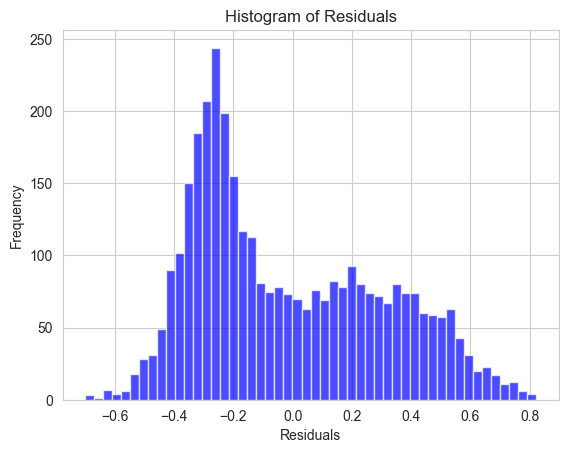

In [40]:
# 평균 잔차 계산
mean_residuals = residuals.mean(axis=0)

# 히스토그램으로 평균 잔차 시각화
plt.hist(mean_residuals, bins=50, facecolor='blue', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

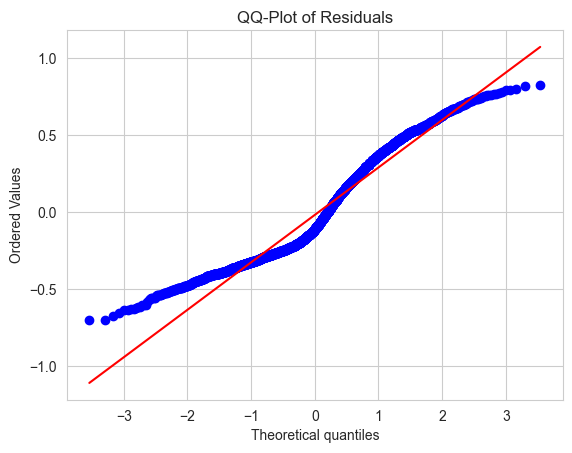

In [41]:
stats.probplot(mean_residuals, plot=plt)
plt.title('QQ-Plot of Residuals')
plt.show()

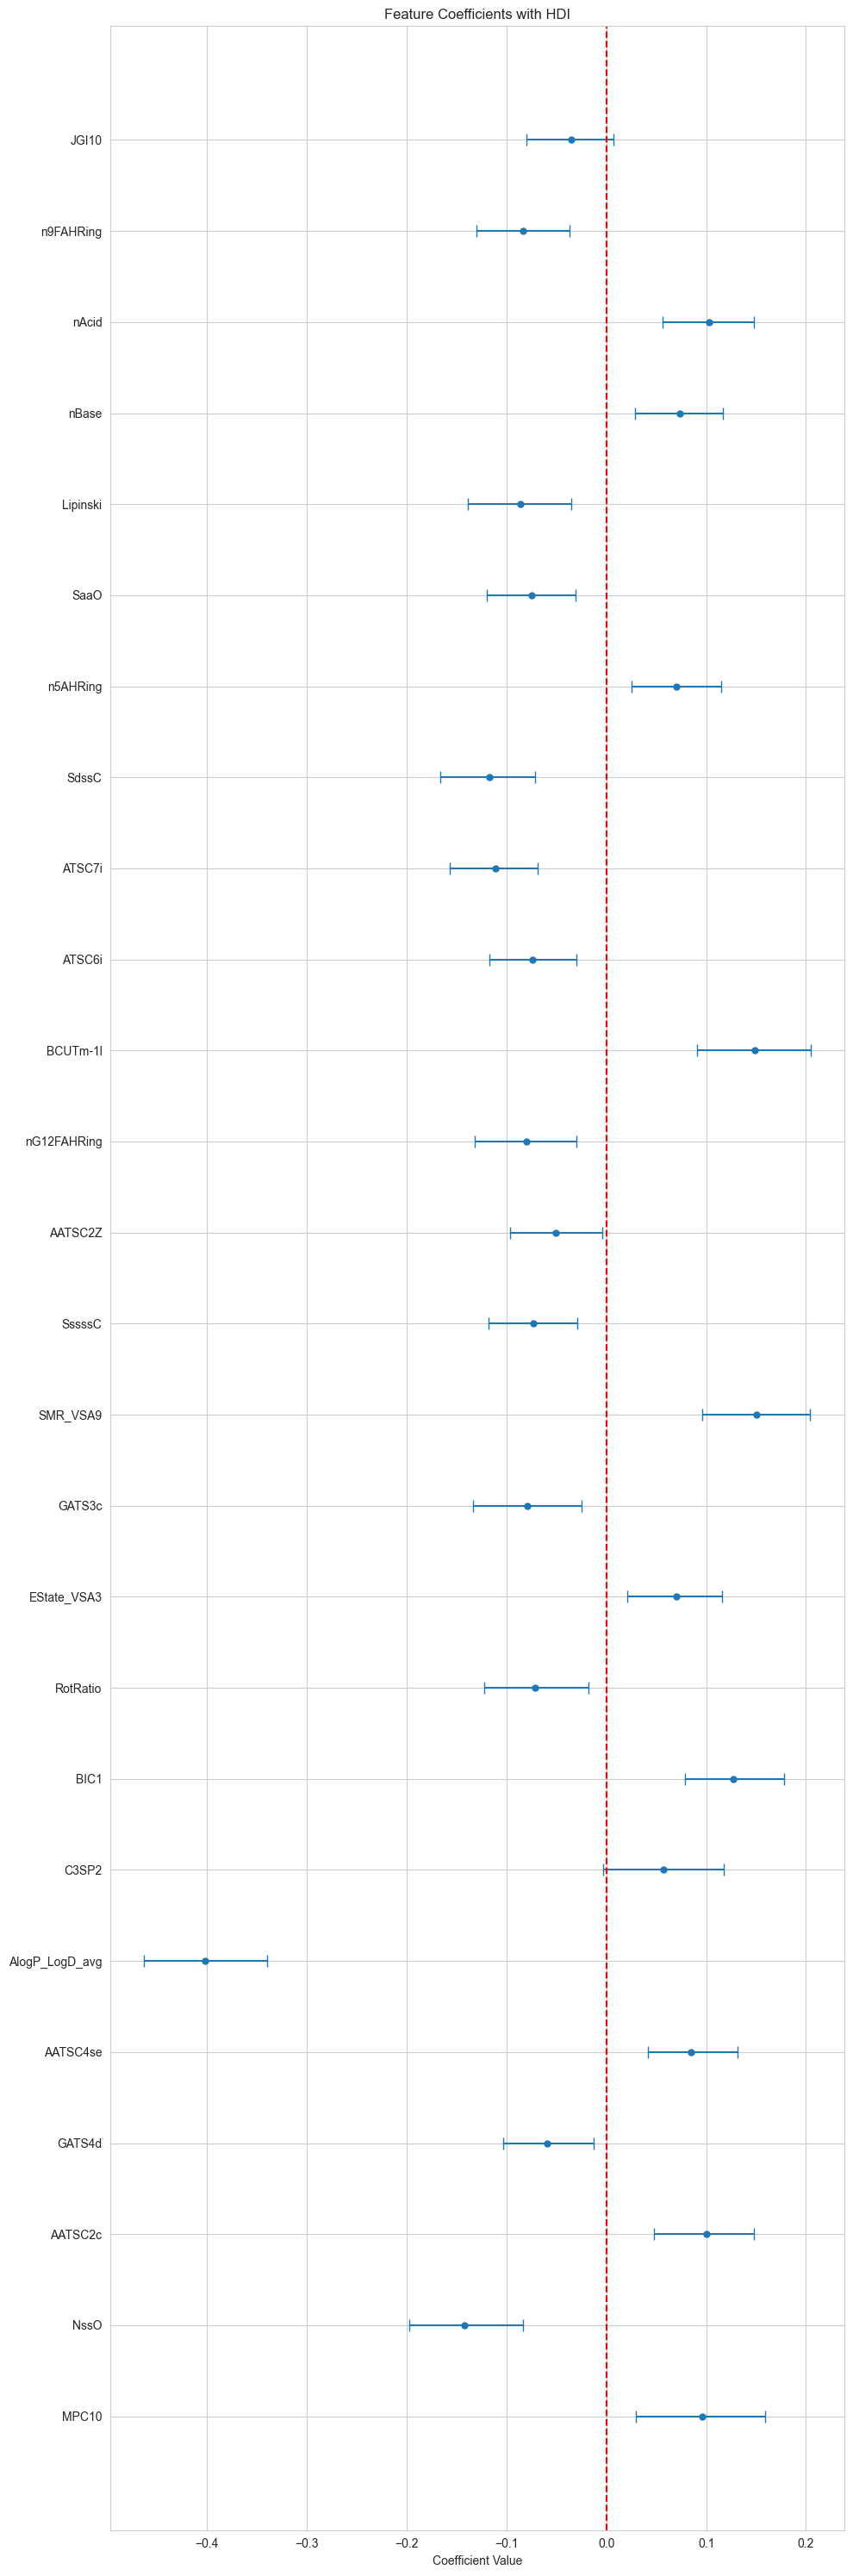

In [42]:
# Extract coefficients and their HDIs
coeff_mean = summary.loc['Coeffs_mu[0]':'Coeffs_mu[{}]'.format(n_predictors-1), 'mean'].values
coeff_hdi_3 = summary.loc['Coeffs_mu[0]':'Coeffs_mu[{}]'.format(n_predictors-1), 'hdi_3%'].values
coeff_hdi_97 = summary.loc['Coeffs_mu[0]':'Coeffs_mu[{}]'.format(n_predictors-1), 'hdi_97%'].values
feature_names = train_beta_df_MLM.columns

# Plot
plt.figure(figsize=(10, 30))
plt.errorbar(coeff_mean, range(n_predictors), xerr=(coeff_mean - coeff_hdi_3, coeff_hdi_97 - coeff_mean), 
             fmt='o', markersize=5, capsize=5)
plt.yticks(range(n_predictors), feature_names)
plt.axvline(x=0, linestyle='--', color='red')
plt.title("Feature Coefficients with HDI")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

Sampling: [y_obs]


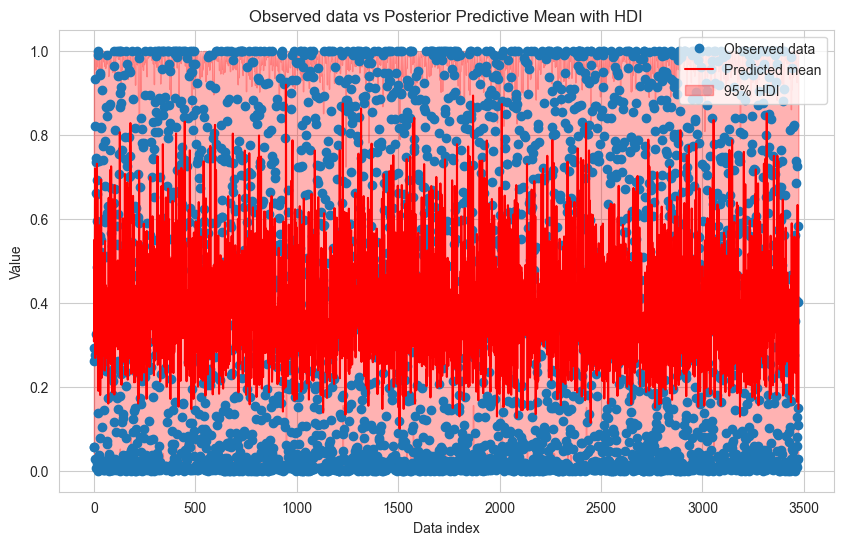

In [43]:
with model_MLM:
    # Get posterior predictive samples
    posterior_predictive = pm.sample_posterior_predictive(trace_MLM, model=model_MLM)

# Extract the predicted values
y_pred_samples = posterior_predictive['posterior_predictive']['y_obs']

# Flatten the first two dimensions
flattened_samples = y_pred_samples.values.reshape(-1, y_pred_samples.shape[-1])

# Calculate mean and percentiles for visualization
y_pred_mean = np.mean(flattened_samples, axis=0)
y_pred_hdi_2_5 = np.percentile(flattened_samples, 2.5, axis=0)
y_pred_hdi_97_5 = np.percentile(flattened_samples, 97.5, axis=0)

# Plotting observed data and predicted data with HDI
plt.figure(figsize=(10, 6))
plt.plot(y, 'o', label='Observed data')
plt.plot(y_pred_mean, 'r', label='Predicted mean')
plt.fill_between(range(len(y)), y_pred_hdi_2_5, y_pred_hdi_97_5, color='red', alpha=0.3, label='95% HDI')
plt.legend()
plt.title("Observed data vs Posterior Predictive Mean with HDI")
plt.xlabel("Data index")
plt.ylabel("Value")
plt.show()

In [86]:
# Define independent and dependent variables
X2 = X = train_beta_df_HLM_true.values
y2 = train_beta_df_HLM["HLM_normalized"].values

alpha_hlm, beta_hlm = result_hlm.x

# Shape of the predictors
n_predictors_2 = X2.shape[1]

with pm.Model() as model_HLM:
    # Priors for intercept and coefficients
    intercept_mu_2 = pm.Normal('Intercept_mu_2', mu=alpha_hlm / (alpha_hlm + beta_hlm), sigma=10)
    coeffs_mu_2 = pm.Normal('Coeffs_mu_2', mu=0, sigma=10, shape=n_predictors_2)

    intercept_phi_2 = pm.Normal('Intercept_phi_2', mu=np.log(alpha_hlm + beta_hlm), sigma=10)
    coeffs_phi_2 = pm.Normal('Coeffs_phi_2', mu=0, sigma=10, shape=n_predictors_2)
    
    # Linear combination of predictors for mu and phi (precision of beta distribution)
    mu_logit_2 = intercept_mu_2 + pm.math.dot(X2, coeffs_mu_2)
    phi_logit_2 = intercept_phi_2 + pm.math.dot(X2, coeffs_phi_2)
    
    # Convert logits to probabilities for mu and phi
    mu_2 = pm.Deterministic('mu_2', pm.math.invlogit(mu_logit_2))
    phi_2 = pm.math.exp(phi_logit_2)
    
    # Calculate alpha and beta based on mu and phi
    alpha_2 = mu_2 * phi_2
    beta_2 = (1 - mu_2) * phi_2
    
    # Likelihood (Beta regression)
    y_obs_2 = pm.Beta('y_obs_2', alpha=alpha_2, beta=beta_2, observed=y2)
    
    start_2 = pm.find_MAP()

    step_2 = pm.Slice()

    # Sample the model
    trace_HLM = pm.sample(2500, tune=2000, chains=4, start=start_2, step=step_2, return_inferencedata=True)

# Model summary
summary_2 = pm.summary(trace_HLM)
summary_2

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [Intercept_mu_2]
>Slice: [Coeffs_mu_2]
>Slice: [Intercept_phi_2]
>Slice: [Coeffs_phi_2]


Sampling 4 chains for 2_000 tune and 2_500 draw iterations (8_000 + 10_000 draws total) took 312 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept_mu_2,0.167,0.023,0.123,0.210,0.000,0.0,6555.0,6621.0,1.0
Coeffs_mu_2[0],0.075,0.025,0.028,0.121,0.000,0.0,5771.0,6900.0,1.0
Coeffs_mu_2[1],0.179,0.036,0.113,0.248,0.001,0.0,2754.0,4755.0,1.0
Coeffs_mu_2[2],0.082,0.024,0.038,0.127,0.000,0.0,6689.0,6703.0,1.0
Coeffs_mu_2[3],-0.174,0.026,-0.222,-0.123,0.000,0.0,4190.0,5963.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_2[3469],0.570,0.033,0.507,0.630,0.000,0.0,4406.0,7012.0,1.0
mu_2[3470],0.441,0.024,0.397,0.486,0.000,0.0,4105.0,5998.0,1.0
mu_2[3471],0.572,0.018,0.539,0.607,0.000,0.0,6276.0,8148.0,1.0
mu_2[3472],0.452,0.025,0.405,0.500,0.000,0.0,7704.0,9014.0,1.0


In [87]:
model_HLM.debug()

point={'Intercept_mu_2': array(0.53067274), 'Coeffs_mu_2': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), 'Intercept_phi_2': array(-0.08590508), 'Coeffs_phi_2': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])}

No problems found


In [88]:
posterior_predictive = pm.sample_posterior_predictive(trace_HLM, model=model_HLM)
y_pred = posterior_predictive['posterior_predictive']['y_obs_2'].values.mean(axis=0)
residuals = y - y_pred

residuals

Sampling: [y_obs_2]


array([[-0.05123219, -0.31108736, -0.68183512, ...,  0.03289339,
         0.17275919, -0.21781494],
       [-0.02450242, -0.23308878, -0.73178028, ..., -0.33809386,
        -0.22262531, -0.12684912],
       [-0.52816041, -0.22475143, -0.68835528, ..., -0.18022417,
        -0.09869388, -0.01822648],
       ...,
       [-0.12880635, -0.42854771, -0.71236879, ...,  0.03231401,
         0.16065617, -0.12953307],
       [-0.38423433, -0.31564462, -0.67831428, ...,  0.05707651,
        -0.12026478, -0.40560138],
       [ 0.01395122, -0.28925506, -0.66404386, ..., -0.49373135,
         0.14052035,  0.0044425 ]])

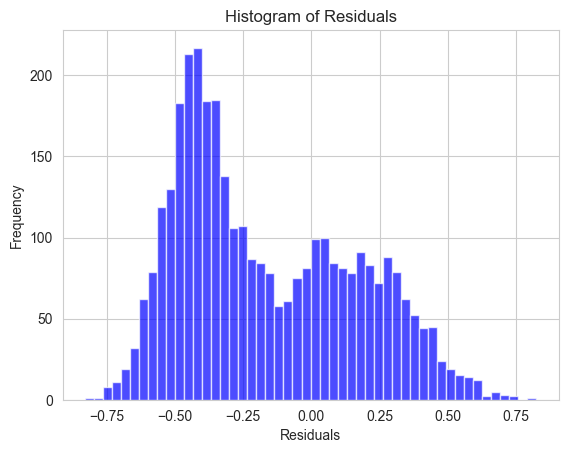

In [89]:
# 평균 잔차 계산
mean_residuals = residuals.mean(axis=0)

# 히스토그램으로 평균 잔차 시각화
plt.hist(mean_residuals, bins=50, facecolor='blue', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

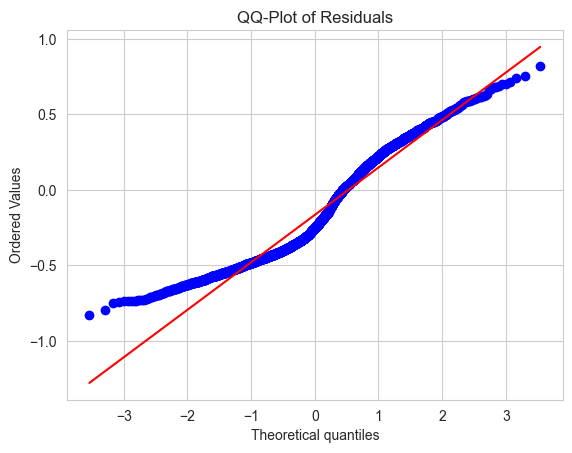

In [90]:
stats.probplot(mean_residuals, plot=plt)
plt.title('QQ-Plot of Residuals')
plt.show()

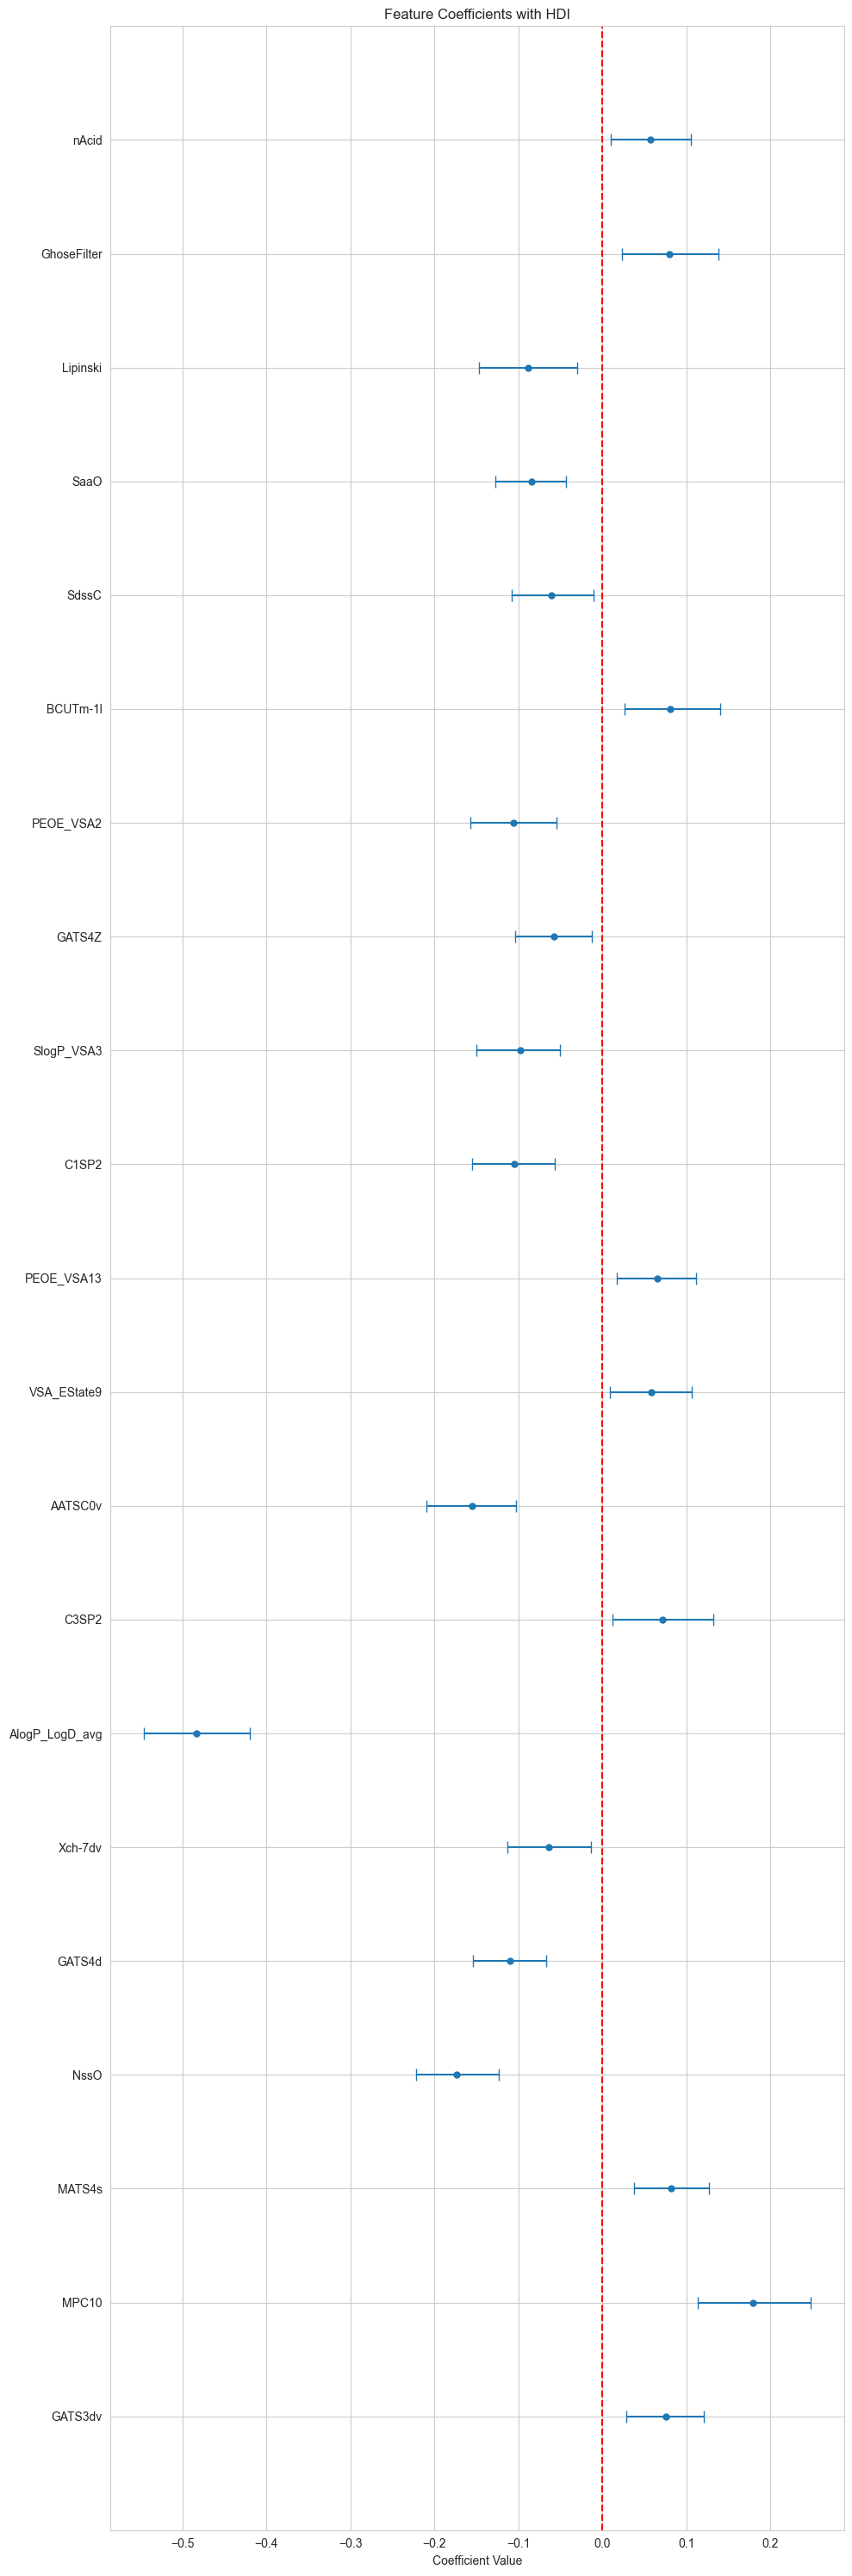

In [91]:
# Extract coefficients and their HDIs
coeff_mean = summary_2.loc['Coeffs_mu_2[0]':'Coeffs_mu_2[{}]'.format(n_predictors_2-1), 'mean'].values
coeff_hdi_3 = summary_2.loc['Coeffs_mu_2[0]':'Coeffs_mu_2[{}]'.format(n_predictors_2-1), 'hdi_3%'].values
coeff_hdi_97 = summary_2.loc['Coeffs_mu_2[0]':'Coeffs_mu_2[{}]'.format(n_predictors_2-1), 'hdi_97%'].values
feature_names = train_beta_df_HLM.columns

# Plot
plt.figure(figsize=(10, 30))
plt.errorbar(coeff_mean, range(n_predictors_2), xerr=(coeff_mean - coeff_hdi_3, coeff_hdi_97 - coeff_mean), 
             fmt='o', markersize=5, capsize=5)
plt.yticks(range(n_predictors_2), feature_names)
plt.axvline(x=0, linestyle='--', color='red')
plt.title("Feature Coefficients with HDI")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

Sampling: [y_obs_2]


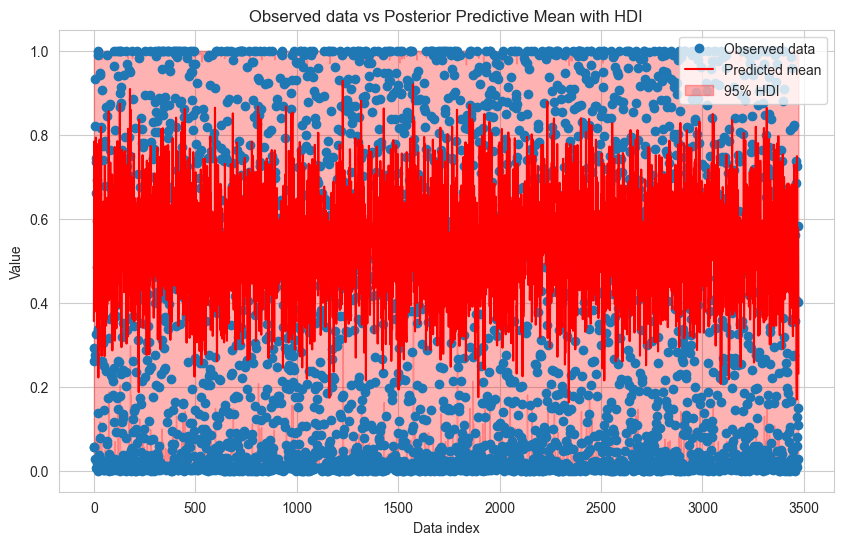

In [92]:
with model_HLM:
    # Get posterior predictive samples
    posterior_predictive = pm.sample_posterior_predictive(trace_HLM, model=model_HLM)

# Extract the predicted values
y_pred_samples = posterior_predictive['posterior_predictive']['y_obs_2']

# Flatten the first two dimensions
flattened_samples = y_pred_samples.values.reshape(-1, y_pred_samples.shape[-1])

# Calculate mean and percentiles for visualization
y_pred_mean = np.mean(flattened_samples, axis=0)
y_pred_hdi_2_5 = np.percentile(flattened_samples, 2.5, axis=0)
y_pred_hdi_97_5 = np.percentile(flattened_samples, 97.5, axis=0)

# Plotting observed data and predicted data with HDI
plt.figure(figsize=(10, 6))
plt.plot(y, 'o', label='Observed data')
plt.plot(y_pred_mean, 'r', label='Predicted mean')
plt.fill_between(range(len(y)), y_pred_hdi_2_5, y_pred_hdi_97_5, color='red', alpha=0.3, label='95% HDI')
plt.legend()
plt.title("Observed data vs Posterior Predictive Mean with HDI")
plt.xlabel("Data index")
plt.ylabel("Value")
plt.show()

In [54]:
test_beta_df_MLM_true = test_final_scaled.copy()
test_beta_df_HLM_true = test_final_scaled.copy()

In [55]:
test_beta_df_MLM_true

,MPC10,NssO,AATSC2c,GATS4d,AATSC4se,AlogP_LogD_avg,C3SP2,BIC1,RotRatio,EState_VSA3,...,ATSC6i,ATSC7i,SdssC,n5AHRing,SaaO,Lipinski,nBase,nAcid,n9FAHRing,JGI10
0,-0.244881,-0.745715,0.374231,-0.113979,0.467183,-0.077275,-1.300738,0.027461,1.419531,-0.496966,...,-2.551573,1.486298,0.301360,-0.446041,-0.365855,0.34838,1.298524,-0.236496,-0.308332,-0.230570
1,0.119079,2.342026,-0.101571,-0.694901,1.128184,-1.350089,-0.580846,-0.122357,-0.777459,2.447904,...,2.030142,-0.594869,0.018735,1.767596,-0.365855,0.34838,-0.421290,-0.236496,-0.308332,0.347347
2,-0.487520,-0.745715,2.778216,0.187836,1.381776,0.942587,0.858939,0.025899,-0.678923,-0.504607,...,-1.616666,0.768387,0.195082,-0.446041,-0.365855,0.34838,4.738153,-0.236496,-0.308332,0.160887
3,0.745898,-0.745715,0.503660,0.400005,0.158236,-0.599916,-0.580846,0.498894,-1.237294,-0.021395,...,-0.503366,0.700188,-0.154611,-0.446041,-0.365855,0.34838,-0.421290,-0.236496,3.092128,-0.283978
4,0.756008,-0.745715,-0.162803,-0.739020,0.040665,-1.282511,0.139047,-0.289982,-1.205582,1.300171,...,1.447810,-2.341943,0.238421,-0.446041,-0.365855,0.34838,1.298524,-0.236496,-0.308332,0.752248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,-0.912140,-0.745715,0.016463,-0.278044,-0.390467,0.895469,-0.580846,-2.256092,2.041530,-0.516019,...,0.092076,1.434856,0.479988,-0.446041,2.194473,0.34838,-0.421290,-0.236496,-0.308332,-0.417706
479,-0.487520,0.283532,0.308159,-0.187410,0.023830,-2.439389,0.139047,-1.960661,-1.626386,2.430311,...,-0.163644,-1.296018,1.128138,1.767596,-0.365855,0.34838,1.298524,-0.236496,-0.308332,0.900831
480,1.170518,-0.745715,0.714795,0.308647,-0.084383,-0.601776,0.858939,-0.069895,-0.729890,-0.133347,...,0.644199,-1.463706,-0.817754,1.767596,-0.365855,0.34838,-0.421290,-0.236496,-0.308332,1.613525
481,-0.851480,-0.745715,-0.665444,-0.569822,2.209177,-1.336759,-0.580846,2.620534,-0.843150,-1.425782,...,-0.354518,0.940739,-1.030000,-0.446041,-0.365855,0.34838,-0.421290,-0.236496,-0.308332,-0.542374


In [56]:
test_beta_df_HLM_true

,GATS3dv,MPC10,MATS4s,NssO,GATS4d,Xch-7dv,AlogP_LogD_avg,C3SP2,AATSC0v,VSA_EState9,...,C1SP2,SlogP_VSA3,GATS4Z,PEOE_VSA2,BCUTm-1l,SdssC,SaaO,Lipinski,GhoseFilter,nAcid
0,0.414685,-0.244881,0.435069,-0.745715,-0.113979,-0.482674,-0.077275,-1.300738,0.595031,-0.056580,...,0.54824,-0.572155,-1.484867,-0.318907,1.719055,0.301360,-0.365855,0.34838,0.372348,-0.236496
1,1.294560,0.119079,0.137298,2.342026,-0.694901,-0.168417,-1.350089,-0.580846,-0.256400,0.598049,...,0.54824,-0.218734,0.683228,1.391682,0.001085,0.018735,-0.365855,0.34838,0.372348,-0.236496
2,0.201888,-0.487520,2.036190,-0.745715,0.187836,-0.663215,0.942587,0.858939,0.108039,-0.056580,...,-0.84451,-0.587109,-0.433472,-0.224773,-0.238683,0.195082,-0.365855,0.34838,0.372348,-0.236496
3,-1.361946,0.745898,-0.265115,-0.745715,0.400005,-0.077495,-0.599916,-0.580846,-1.436660,-0.056580,...,1.94099,-0.572155,0.054972,0.567140,-0.256247,-0.154611,-0.365855,0.34838,0.372348,-0.236496
4,-0.780900,0.756008,-0.213974,-0.745715,-0.739020,0.153311,-1.282511,0.139047,-0.205813,0.749590,...,1.94099,-0.511471,0.238709,1.360930,0.527317,0.238421,-0.365855,0.34838,0.372348,-0.236496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,0.557890,-0.912140,-0.312247,-0.745715,-0.278044,-0.077908,0.895469,-0.580846,0.115275,-0.056580,...,-0.84451,1.540942,0.979023,-0.338380,1.318110,0.479988,2.194473,0.34838,0.372348,-0.236496
479,0.883027,-0.487520,-0.503395,0.283532,-0.187410,0.517482,-2.439389,0.139047,-0.537981,0.854647,...,0.54824,0.945281,0.512093,0.547667,0.598387,1.128138,-0.365855,0.34838,0.372348,-0.236496
480,-1.340876,1.170518,-0.042021,-0.745715,0.308647,0.165736,-0.601776,0.858939,-0.112201,-0.056580,...,0.54824,-0.783343,-0.843075,2.339233,-0.377663,-0.817754,-0.365855,0.34838,0.372348,-0.236496
481,-0.703483,-0.851480,1.416724,-0.745715,-0.569822,-0.643510,-1.336759,-0.580846,-0.701950,0.696291,...,0.54824,-0.511471,-1.799526,0.547667,-0.203972,-1.030000,-0.365855,0.34838,0.372348,-0.236496


In [82]:
X_test_MLM = test_beta_df_MLM_true.values
X_test_HLM = test_beta_df_HLM_true.values

In [58]:
with model_MLM:
    # Linear combination of predictors for mu and phi using test data
    mu_logit_test = intercept_mu + pm.math.dot(X_test_MLM, coeffs_mu)
    phi_logit_test = intercept_phi + pm.math.dot(X_test_MLM, coeffs_phi)

    # Convert logits to probabilities for mu and phi
    mu_test = pm.Deterministic('mu_test', pm.math.invlogit(mu_logit_test))
    phi_test = pm.math.exp(phi_logit_test)

    # Calculate alpha and beta based on mu and phi
    alpha_test = mu_test * phi_test
    beta_test = (1 - mu_test) * phi_test

    # Predictive distribution for test data
    y_test_pred_MLM = pm.Beta('y_test_pred_MLM', alpha=alpha_test, beta=beta_test)

In [59]:
with model_MLM:
    posterior_predictive_test = pm.sample_posterior_predictive(trace_MLM, var_names=['y_test_pred_MLM'])

Sampling: [y_test_pred_MLM]


In [77]:
y_pred_test_samples_MLM = posterior_predictive_test['posterior_predictive']['y_test_pred_MLM']

# 모든 체인의 예측 샘플들을 합쳐서 하나의 배열로 만듭니다.
all_samples = y_pred_test_samples_MLM.values.reshape(-1, y_pred_test_samples_MLM.shape[-1])

# 각 데이터 포인트별로 KDE를 계산하고 중앙값을 찾습니다.
medians = []
for i in range(all_samples.shape[1]):
    samples = all_samples[:, i]
    median_value = np.median(samples)
    medians.append(median_value)

medians = np.array(medians)
medians

# final_predictions = mean_predictions.mean(axis=1)
# final_predictions


array([3.09368874e-01, 5.42956110e-01, 4.12185744e-01, 4.28567704e-01,
       7.15221333e-01, 3.36924852e-01, 1.87202514e-01, 1.64313516e-01,
       1.58825983e-01, 2.42679527e-01, 1.61573639e-01, 3.38964745e-01,
       5.35859294e-01, 2.41555227e-01, 1.74511412e-01, 5.86432014e-01,
       8.49212937e-04, 2.99644609e-01, 7.15940182e-01, 3.67694701e-01,
       8.22666620e-02, 6.32735589e-02, 6.86296065e-02, 6.65749634e-02,
       1.20548379e-01, 1.86331843e-01, 1.65746203e-01, 4.87451883e-01,
       1.67455550e-01, 7.93129649e-01, 2.41140666e-01, 1.36685990e-01,
       6.96488598e-02, 3.45698760e-01, 1.27271614e-01, 1.08576886e-02,
       2.55440632e-01, 4.00126496e-01, 3.95423243e-01, 1.86797781e-01,
       9.40831889e-02, 2.51071492e-01, 2.06795347e-01, 2.08839934e-01,
       1.87462369e-01, 4.98998875e-01, 2.39443942e-01, 1.99034907e-01,
       4.01620904e-01, 1.52426615e-01, 7.06073201e-01, 1.60404345e-01,
       3.81431170e-01, 4.16366072e-01, 8.07451312e-02, 1.26757032e-01,
      

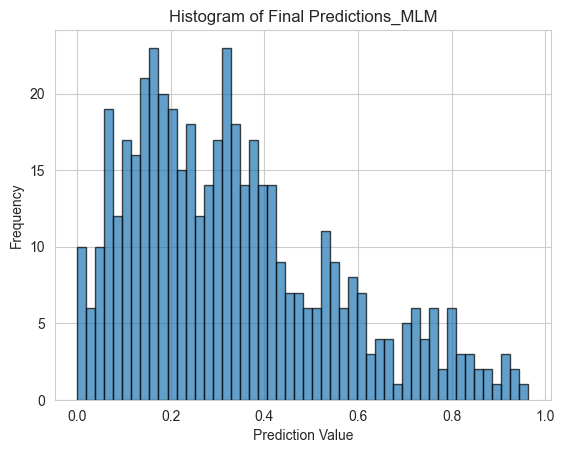

In [80]:
plt.hist(medians, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Final Predictions_MLM')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()

In [93]:
with model_HLM:
    # Linear combination of predictors for mu and phi using test data
    mu_logit_test_2 = intercept_mu_2 + pm.math.dot(X_test_HLM, coeffs_mu_2)  # 변수 이름 변경
    phi_logit_test_2 = intercept_phi_2 + pm.math.dot(X_test_HLM, coeffs_phi_2)  # 변수 이름 변경

    # Convert logits to probabilities for mu and phi
    mu_test_2 = pm.Deterministic('mu_test_2', pm.math.invlogit(mu_logit_test_2))  # 변수 이름 변경
    phi_test_2 = pm.math.exp(phi_logit_test_2)  # 변수 이름 변경

    # Calculate alpha and beta based on mu and phi
    alpha_test_2 = mu_test_2 * phi_test_2  # 변수 이름 변경
    beta_test_2 = (1 - mu_test_2) * phi_test_2  # 변수 이름 변경

    # Predictive distribution for test data
    y_test_pred_HLM = pm.Beta('y_test_pred_HLM', alpha=alpha_test_2, beta=beta_test_2)  # 변수 이름 변경

In [94]:
with model_HLM:
    posterior_predictive_test = pm.sample_posterior_predictive(trace_HLM, var_names=['y_test_pred_HLM'])

Sampling: [y_test_pred_HLM]


In [95]:
y_pred_test_samples_HLM = posterior_predictive_test['posterior_predictive']['y_test_pred_HLM']

# 모든 체인의 예측 샘플들을 합쳐서 하나의 배열로 만듭니다.
all_samples = y_pred_test_samples_HLM.values.reshape(-1, y_pred_test_samples_HLM.shape[-1])

# 각 데이터 포인트별로 KDE를 계산하고 중앙값을 찾습니다.
medians_HLM = []
for i in range(all_samples.shape[1]):
    samples = all_samples[:, i]
    median_value = np.median(samples)
    medians_HLM.append(median_value)

medians_HLM = np.array(medians_HLM)
medians_HLM

array([6.94592116e-01, 7.40676867e-01, 5.46356912e-01, 7.84847919e-01,
       8.76988263e-01, 8.36731885e-01, 4.93554535e-01, 4.27894425e-01,
       3.46599425e-01, 4.97061225e-01, 3.79374043e-01, 6.86132418e-01,
       6.08909546e-01, 5.10954602e-01, 3.32753761e-01, 8.81367787e-01,
       1.70879984e-04, 6.74021673e-01, 8.47702132e-01, 7.73841627e-01,
       4.10706263e-01, 2.79178444e-01, 1.63946504e-01, 4.81432322e-01,
       1.10590062e-01, 5.43031838e-01, 4.80856132e-01, 8.42693884e-01,
       5.59161543e-01, 9.59556438e-01, 5.88249235e-01, 4.08594059e-01,
       4.81231362e-01, 6.12760655e-01, 5.46691421e-01, 2.75531996e-01,
       6.12683016e-01, 7.88597199e-01, 6.00643264e-01, 6.05459878e-01,
       2.70591847e-01, 8.18858367e-01, 1.18994671e-01, 4.83156896e-01,
       3.21834589e-01, 8.65192128e-01, 3.95208208e-01, 4.85866493e-01,
       6.57230581e-01, 3.92782685e-01, 8.36113845e-01, 4.73247774e-01,
       5.91409203e-01, 3.62494344e-01, 3.73140360e-01, 4.60479079e-01,
      

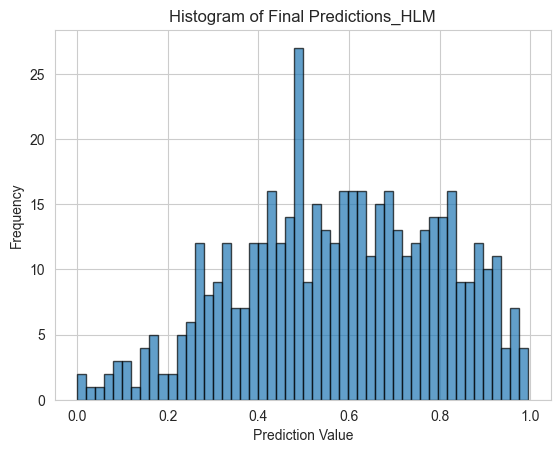

In [96]:
plt.hist(medians_HLM, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Final Predictions_HLM')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()

In [97]:
sample_submission = pd.read_csv('/Users/seunghoonchoi/Downloads/SKKU KDT 2기/공모전/Dacon_making_new_medicine/Data/sample_submission.csv')
sample_submission['MLM'] = medians * 100
sample_submission['HLM'] = medians_HLM * 100
sample_submission

,id,MLM,HLM
0,TEST_000,30.936887,69.459212
1,TEST_001,54.295611,74.067687
2,TEST_002,41.218574,54.635691
3,TEST_003,42.856770,78.484792
4,TEST_004,71.522133,87.698826
...,...,...,...
478,TEST_478,2.373534,25.703529
479,TEST_479,78.436450,90.552605
480,TEST_480,45.629391,80.377955
481,TEST_481,72.807757,91.100378


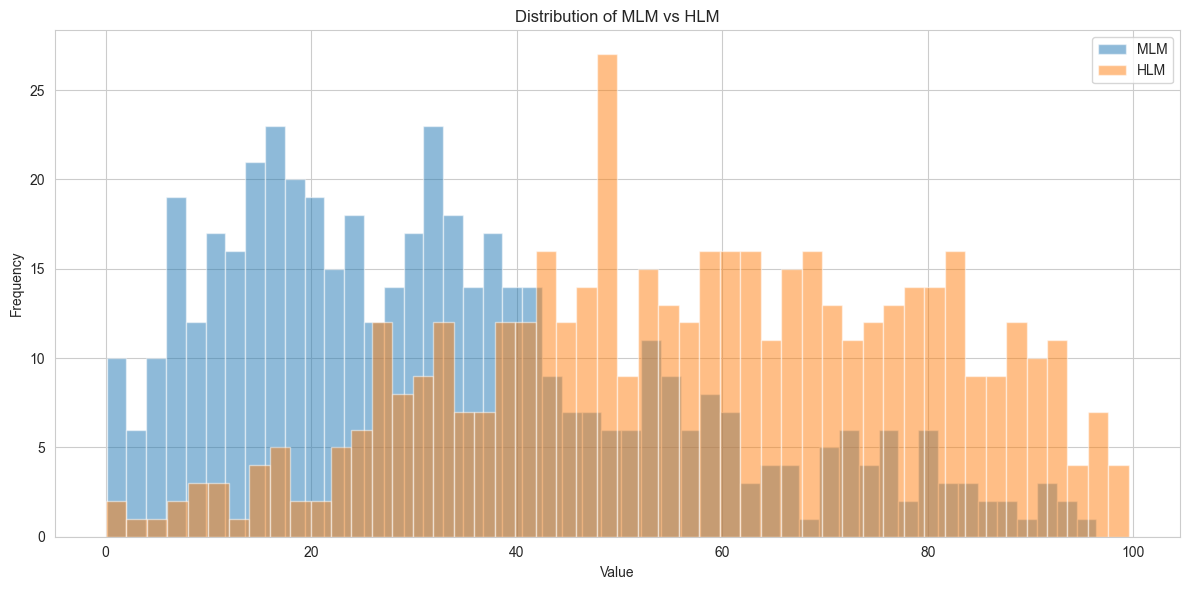

In [98]:
# Plot histograms for MLM and HLM
plt.figure(figsize=(12, 6))

plt.hist(sample_submission['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(sample_submission['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [99]:
sample_submission.to_csv('beta_regression.csv', index=False)